In [1]:
import os
import random

import numpy as np
import pandas as pd
import torch
import matplotlib.pyplot as plt
import datetime
import math

from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim.lr_scheduler import StepLR
from scipy.interpolate import make_interp_spline
from itertools import chain

In [2]:
#data process 
#读入, 归一化, 装载dataset

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
LSTM_PATH = 'E:\\实验数据\\python\\LSTM_data\\test.pkl'
torch.manual_seed(60)

def load_data(file_name):
    global MAX, MIN
    df = pd.read_csv(file_name, encoding='gbk')
    columns = df.columns
    df.fillna(df.mean(), inplace=True)
    
    MAX = np.max(df[columns[2]])
    MIN = np.min(df[columns[2]])
    
    for i in range(len(columns)):
        max_v = np.max(df[columns[i]])
        min_v = np.min(df[columns[i]])
        df[columns[i]] = (df[columns[i]] - min_v) / (max_v - min_v)

    return df


class MyDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __getitem__(self, item):
        return self.data[item]

    def __len__(self):
        return len(self.data)
    

def nn_seq(file_name, batch_size):
    global test_len
    print('data processing...')
    data = load_data(file_name)
    load = data[data.columns[2]]
    load = load.tolist()
    load = torch.FloatTensor(load).view(-1)
    data = data.values.tolist()
    seq = []
    for i in range(len(data) - time_seq_len):
        train_seq = []
        train_label = []
        for j in range(i, i + time_seq_len):   #每24个时刻作为一个输入
            x = [load[j]]
            for c in range(0,2):
                x.append(data[j][c])
            train_seq.append(x)
        train_label.append(load[i+time_seq_len])
        train_seq = torch.FloatTensor(train_seq)
        train_label = torch.FloatTensor(train_label).view(-1)
        seq.append((train_seq, train_label))
#     print(seq[:5])
            

    Dtr = seq[0:int(len(seq) * 0.7)]    #将所有数据中的前百分之七十作为训练集
    Dte = seq[int(len(seq) * 0.7):len(seq)]
    test_len = len(Dte)

    train_len = int(len(Dtr) / batch_size) * batch_size  #可能训练集不能被 batch_size整除, 因此这里取个最大能整除的长度
    test_len = int(len(Dte) / batch_size) * batch_size
    Dtr, Dte = Dtr[:train_len], Dte[:test_len]

    train = MyDataset(Dtr)
    test = MyDataset(Dte)

    Dtr = DataLoader(dataset=train, batch_size=batch_size, shuffle=False, num_workers=0)
    Dte = DataLoader(dataset=test, batch_size=batch_size, shuffle=False, num_workers=0)

    return Dtr, Dte


def get_rmse(x, y):
    """
    :param x: true value
    :param y: pred value
    :return: mape
    """
    error = x-y
    return np.mean(error ** 2) ** 0.5

def get_mae(x, y):
    error = abs(x-y)
    return np.mean(error)

def computeCorrelation(X, Y):
    xBar = np.mean(X)
    yBar = np.mean(Y)
    SSR = 0
    varX = 0
    varY = 0
    for i in range(0 , len(X)):
        diffXXBar = X[i] - xBar
        diffYYBar = Y[i] - yBar
        SSR += (diffXXBar * diffYYBar)
        varX +=  diffXXBar**2
        varY += diffYYBar**2
    
    SST = math.sqrt(varX * varY)
    r_squared = (SSR / SST)**2
    return r_squared


In [3]:
# dt, de = nn_seq('E:\实验数据\python\LSTM_data\data.csv', 5)
# print(len(dt))
# print(len(de))
# print(test_len)

In [4]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, batch_size):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.output_size = output_size
        self.num_directions = 1 # 单向LSTM
        self.batch_size = batch_size
        self.lstm = nn.GRU(self.input_size, self.hidden_size, self.num_layers, batch_first=True)
        self.linear = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input_seq):
        seq_len = input_seq.shape[1] # (5, 24)
        # input(batch_size, seq_len, input_size)
        input_seq = input_seq.view(self.batch_size, seq_len, 3)  # (5, 24, 1)
        # output(batch_size, seq_len, num_directions * hidden_size)
        output, _ = self.lstm(input_seq) # output(5, 24, 64)
        output = output.contiguous().view(self.batch_size * seq_len, self.hidden_size) # (5 * 24, 64)
        pred = self.linear(output) # pred(150, 1)
        pred = pred.view(self.batch_size, seq_len, -1) # (5, 24, 1)
        pred = pred[:, -1, :]  # (5, 1)
        return pred

In [5]:
ls = []
def LSTM_train(name, b):
    Dtr, Dte = nn_seq(file_name=name, batch_size=b)
    input_size, hidden_size, num_layers, output_size = 3, 64, 1, 1
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=b).to(device)
    loss_function = nn.MSELoss().to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
    # 训练
    epochs = 100
    cnt = 0
    for i in range(epochs):
        cnt = 0
        print('epoch', i)
        for (seq, label) in Dtr:
            cnt += 1
            seq = seq.to(device)
            label = label.to(device)
            y_pred = model(seq)
            loss = loss_function(y_pred, label)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            if cnt % 100 == 0:
                print('epoch', i, ':', cnt - 100, '~', cnt, loss.item())
        ls.append(loss.item())
    state = {'model': model.state_dict(), 'optimizer': optimizer.state_dict()}
    torch.save(state, LSTM_PATH)

# LSTM_train('E:\实验数据\python\LSTM_data\data.csv', 5)

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.014401783235371113
epoch 0 : 100 ~ 200 0.013756589964032173
epoch 1
epoch 1 : 0 ~ 100 0.009784629568457603
epoch 1 : 100 ~ 200 0.010171258822083473
epoch 2
epoch 2 : 0 ~ 100 0.011438730172812939
epoch 2 : 100 ~ 200 0.009585359133780003
epoch 3
epoch 3 : 0 ~ 100 0.012989123351871967
epoch 3 : 100 ~ 200 0.009713364765048027
epoch 4
epoch 4 : 0 ~ 100 0.013185733929276466
epoch 4 : 100 ~ 200 0.009803409688174725
epoch 5
epoch 5 : 0 ~ 100 0.013139655813574791
epoch 5 : 100 ~ 200 0.009871050715446472
epoch 6
epoch 6 : 0 ~ 100 0.013066263869404793
epoch 6 : 100 ~ 200 0.009931390173733234
epoch 7
epoch 7 : 0 ~ 100 0.012990662828087807
epoch 7 : 100 ~ 200 0.009988549165427685
epoch 8
epoch 8 : 0 ~ 100 0.012914014980196953
epoch 8 : 100 ~ 200 0.010044676251709461
epoch 9
epoch 9 : 0 ~ 100 0.012834882363677025
epoch 9 : 100 ~ 200 0.010101410560309887
epoch 10
epoch 10 : 0 ~ 100 0.01275181956589222
epoch 10 : 100 ~ 200 0.010160056874155998
epoch 11
ep

epoch 90 : 100 ~ 200 0.01176888681948185
epoch 91
epoch 91 : 0 ~ 100 0.011421283707022667
epoch 91 : 100 ~ 200 0.011765017174184322
epoch 92
epoch 92 : 0 ~ 100 0.01142712403088808
epoch 92 : 100 ~ 200 0.011760625056922436
epoch 93
epoch 93 : 0 ~ 100 0.011429964564740658
epoch 93 : 100 ~ 200 0.011757959611713886
epoch 94
epoch 94 : 0 ~ 100 0.011435801163315773
epoch 94 : 100 ~ 200 0.011752801947295666
epoch 95
epoch 95 : 0 ~ 100 0.011440741829574108
epoch 95 : 100 ~ 200 0.01174900121986866
epoch 96
epoch 96 : 0 ~ 100 0.011447816155850887
epoch 96 : 100 ~ 200 0.011743075214326382
epoch 97
epoch 97 : 0 ~ 100 0.011452658101916313
epoch 97 : 100 ~ 200 0.011738486588001251
epoch 98
epoch 98 : 0 ~ 100 0.011456143110990524
epoch 98 : 100 ~ 200 0.011734428815543652
epoch 99
epoch 99 : 0 ~ 100 0.011462337337434292
epoch 99 : 100 ~ 200 0.011729279533028603
data processing...
loading model...
predicting...
rmse: 0.8765355590762086


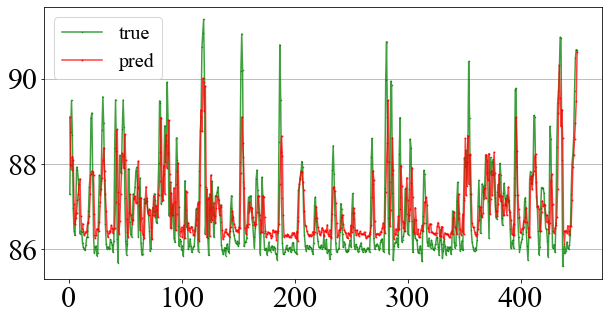

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.007034272886812687
epoch 0 : 100 ~ 200 0.0018011793727055192
epoch 1
epoch 1 : 0 ~ 100 0.005492481403052807
epoch 1 : 100 ~ 200 0.0010494757443666458
epoch 2
epoch 2 : 0 ~ 100 0.004182121250778437
epoch 2 : 100 ~ 200 0.0015233010053634644
epoch 3
epoch 3 : 0 ~ 100 0.003196102101355791
epoch 3 : 100 ~ 200 0.0022373665124177933
epoch 4
epoch 4 : 0 ~ 100 0.0028568196576088667
epoch 4 : 100 ~ 200 0.002679418073967099
epoch 5
epoch 5 : 0 ~ 100 0.0026033478789031506
epoch 5 : 100 ~ 200 0.00290845544077456
epoch 6
epoch 6 : 0 ~ 100 0.002367750508710742
epoch 6 : 100 ~ 200 0.0030929117929190397
epoch 7
epoch 7 : 0 ~ 100 0.002154377056285739
epoch 7 : 100 ~ 200 0.0032892064191401005
epoch 8
epoch 8 : 0 ~ 100 0.0019619581289589405
epoch 8 : 100 ~ 200 0.003495426382869482
epoch 9
epoch 9 : 0 ~ 100 0.0017893494805321097
epoch 9 : 100 ~ 200 0.003683795453980565
epoch 10
epoch 10 : 0 ~ 100 0.0016377208521589637
epoch 10 : 100 ~ 200 0.00381104601547122
e

epoch 89 : 100 ~ 200 0.0010074066231027246
epoch 90
epoch 90 : 0 ~ 100 0.0008029543678276241
epoch 90 : 100 ~ 200 0.0010018132161349058
epoch 91
epoch 91 : 0 ~ 100 0.0007997934008017182
epoch 91 : 100 ~ 200 0.0009962707990780473
epoch 92
epoch 92 : 0 ~ 100 0.0007964600808918476
epoch 92 : 100 ~ 200 0.0009907956700772047
epoch 93
epoch 93 : 0 ~ 100 0.0007929608109407127
epoch 93 : 100 ~ 200 0.0009854049421846867
epoch 94
epoch 94 : 0 ~ 100 0.0007893173024058342
epoch 94 : 100 ~ 200 0.000980111537501216
epoch 95
epoch 95 : 0 ~ 100 0.0007855448639020324
epoch 95 : 100 ~ 200 0.0009749209275469184
epoch 96
epoch 96 : 0 ~ 100 0.0007816504803486168
epoch 96 : 100 ~ 200 0.0009698352660052478
epoch 97
epoch 97 : 0 ~ 100 0.0007776327547617257
epoch 97 : 100 ~ 200 0.0009648565319366753
epoch 98
epoch 98 : 0 ~ 100 0.0007734874961897731
epoch 98 : 100 ~ 200 0.000959984608925879
epoch 99
epoch 99 : 0 ~ 100 0.0007692144718021154
epoch 99 : 100 ~ 200 0.0009552303818054497
data processing...
loading mo

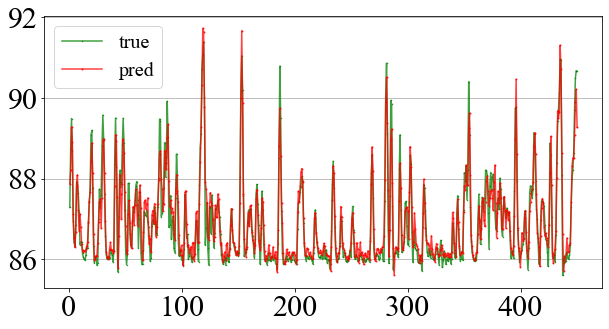

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.002018094528466463
epoch 0 : 100 ~ 200 0.0048115733079612255
epoch 1
epoch 1 : 0 ~ 100 0.006345578469336033
epoch 1 : 100 ~ 200 0.004831260535866022
epoch 2
epoch 2 : 0 ~ 100 0.005440289154648781
epoch 2 : 100 ~ 200 0.005457320716232061
epoch 3
epoch 3 : 0 ~ 100 0.004811860620975494
epoch 3 : 100 ~ 200 0.005926935467869043
epoch 4
epoch 4 : 0 ~ 100 0.004409416578710079
epoch 4 : 100 ~ 200 0.006259370595216751
epoch 5
epoch 5 : 0 ~ 100 0.004032542463392019
epoch 5 : 100 ~ 200 0.006395632866770029
epoch 6
epoch 6 : 0 ~ 100 0.003495285753160715
epoch 6 : 100 ~ 200 0.0062618134543299675
epoch 7
epoch 7 : 0 ~ 100 0.0026099958922713995
epoch 7 : 100 ~ 200 0.005962996277958155
epoch 8
epoch 8 : 0 ~ 100 0.0015805980656296015
epoch 8 : 100 ~ 200 0.005761282052844763
epoch 9
epoch 9 : 0 ~ 100 0.0009766020812094212
epoch 9 : 100 ~ 200 0.005638720467686653
epoch 10
epoch 10 : 0 ~ 100 0.0007431793492287397
epoch 10 : 100 ~ 200 0.005448321346193552
epoc

epoch 89 : 100 ~ 200 0.00266241910867393
epoch 90
epoch 90 : 0 ~ 100 0.00037462753243744373
epoch 90 : 100 ~ 200 0.00267318869009614
epoch 91
epoch 91 : 0 ~ 100 0.00037443876499310136
epoch 91 : 100 ~ 200 0.0026847925037145615
epoch 92
epoch 92 : 0 ~ 100 0.00037428081850521266
epoch 92 : 100 ~ 200 0.002697243820875883
epoch 93
epoch 93 : 0 ~ 100 0.0003741516266018152
epoch 93 : 100 ~ 200 0.0027105561457574368
epoch 94
epoch 94 : 0 ~ 100 0.00037404554313980043
epoch 94 : 100 ~ 200 0.0027247488033026457
epoch 95
epoch 95 : 0 ~ 100 0.00037395823164843023
epoch 95 : 100 ~ 200 0.0027398457750678062
epoch 96
epoch 96 : 0 ~ 100 0.0003738857340067625
epoch 96 : 100 ~ 200 0.0027558659203350544
epoch 97
epoch 97 : 0 ~ 100 0.00037382234586402774
epoch 97 : 100 ~ 200 0.002772834151983261
epoch 98
epoch 98 : 0 ~ 100 0.00037375843385234475
epoch 98 : 100 ~ 200 0.002790784928947687
epoch 99
epoch 99 : 0 ~ 100 0.00037368846824392676
epoch 99 : 100 ~ 200 0.0028097464237362146
data processing...
loading

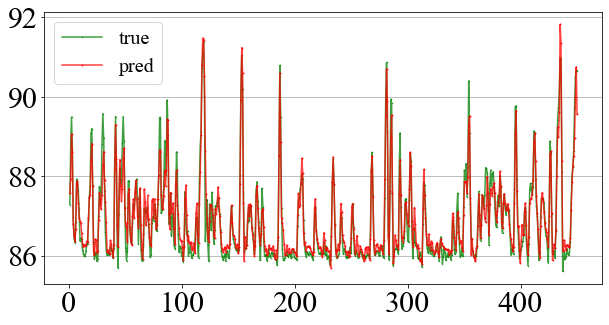

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.0068136840127408504
epoch 0 : 100 ~ 200 0.004858627449721098
epoch 1
epoch 1 : 0 ~ 100 0.009946506470441818
epoch 1 : 100 ~ 200 0.005370144732296467
epoch 2
epoch 2 : 0 ~ 100 0.006836761720478535
epoch 2 : 100 ~ 200 0.0057447985745966434
epoch 3
epoch 3 : 0 ~ 100 0.005418094806373119
epoch 3 : 100 ~ 200 0.005950952414423227
epoch 4
epoch 4 : 0 ~ 100 0.0046206312254071236
epoch 4 : 100 ~ 200 0.006086961831897497
epoch 5
epoch 5 : 0 ~ 100 0.004125821404159069
epoch 5 : 100 ~ 200 0.0061726560816168785
epoch 6
epoch 6 : 0 ~ 100 0.0037919203750789165
epoch 6 : 100 ~ 200 0.006152070127427578
epoch 7
epoch 7 : 0 ~ 100 0.0033845920115709305
epoch 7 : 100 ~ 200 0.005826963577419519
epoch 8
epoch 8 : 0 ~ 100 0.002719620941206813
epoch 8 : 100 ~ 200 0.005478814709931612
epoch 9
epoch 9 : 0 ~ 100 0.002470551524311304
epoch 9 : 100 ~ 200 0.005192608572542667
epoch 10
epoch 10 : 0 ~ 100 0.00251197861507535
epoch 10 : 100 ~ 200 0.004883280955255032
epoch

epoch 89 : 100 ~ 200 0.0023540849797427654
epoch 90
epoch 90 : 0 ~ 100 0.0005051469197496772
epoch 90 : 100 ~ 200 0.0023275818675756454
epoch 91
epoch 91 : 0 ~ 100 0.000514207233209163
epoch 91 : 100 ~ 200 0.0023026191629469395
epoch 92
epoch 92 : 0 ~ 100 0.0005249935202300549
epoch 92 : 100 ~ 200 0.002276003360748291
epoch 93
epoch 93 : 0 ~ 100 0.0005370726576074958
epoch 93 : 100 ~ 200 0.002243420807644725
epoch 94
epoch 94 : 0 ~ 100 0.0005494796787388623
epoch 94 : 100 ~ 200 0.0022032305132597685
epoch 95
epoch 95 : 0 ~ 100 0.0005610983935184777
epoch 95 : 100 ~ 200 0.002159851137548685
epoch 96
epoch 96 : 0 ~ 100 0.000571577693335712
epoch 96 : 100 ~ 200 0.0021227006800472736
epoch 97
epoch 97 : 0 ~ 100 0.0005820338847115636
epoch 97 : 100 ~ 200 0.0021038525737822056
epoch 98
epoch 98 : 0 ~ 100 0.0005946607561782002
epoch 98 : 100 ~ 200 0.002119455486536026
epoch 99
epoch 99 : 0 ~ 100 0.000611672003287822
epoch 99 : 100 ~ 200 0.00216452544555068
data processing...
loading model...


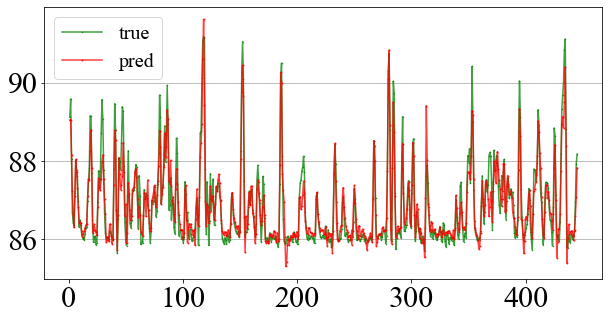

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.035262756049633026
epoch 0 : 100 ~ 200 0.004012066870927811
epoch 1
epoch 1 : 0 ~ 100 0.013984623365104198
epoch 1 : 100 ~ 200 0.004719218704849482
epoch 2
epoch 2 : 0 ~ 100 0.008708653971552849
epoch 2 : 100 ~ 200 0.0049774860963225365
epoch 3
epoch 3 : 0 ~ 100 0.006973188370466232
epoch 3 : 100 ~ 200 0.005094819702208042
epoch 4
epoch 4 : 0 ~ 100 0.006117599550634623
epoch 4 : 100 ~ 200 0.005135859362781048
epoch 5
epoch 5 : 0 ~ 100 0.005673839710652828
epoch 5 : 100 ~ 200 0.005090311169624329
epoch 6
epoch 6 : 0 ~ 100 0.0055212825536727905
epoch 6 : 100 ~ 200 0.004853643011301756
epoch 7
epoch 7 : 0 ~ 100 0.005611879751086235
epoch 7 : 100 ~ 200 0.004462809301912785
epoch 8
epoch 8 : 0 ~ 100 0.005952542182058096
epoch 8 : 100 ~ 200 0.004167390521615744
epoch 9
epoch 9 : 0 ~ 100 0.0062916455790400505
epoch 9 : 100 ~ 200 0.0038580347318202257
epoch 10
epoch 10 : 0 ~ 100 0.006505060009658337
epoch 10 : 100 ~ 200 0.0035364695359021425
epoch

epoch 89 : 0 ~ 100 0.0018000092823058367
epoch 89 : 100 ~ 200 0.0013868570094928145
epoch 90
epoch 90 : 0 ~ 100 0.0018393999198451638
epoch 90 : 100 ~ 200 0.001341835130006075
epoch 91
epoch 91 : 0 ~ 100 0.0018771493341773748
epoch 91 : 100 ~ 200 0.001284469966776669
epoch 92
epoch 92 : 0 ~ 100 0.0019050722476094961
epoch 92 : 100 ~ 200 0.001214262330904603
epoch 93
epoch 93 : 0 ~ 100 0.0019387120846658945
epoch 93 : 100 ~ 200 0.0011265187058597803
epoch 94
epoch 94 : 0 ~ 100 0.0019808642100542784
epoch 94 : 100 ~ 200 0.0010219828691333532
epoch 95
epoch 95 : 0 ~ 100 0.00201159855350852
epoch 95 : 100 ~ 200 0.0008965537999756634
epoch 96
epoch 96 : 0 ~ 100 0.00208171340636909
epoch 96 : 100 ~ 200 0.0007915765163488686
epoch 97
epoch 97 : 0 ~ 100 0.002162610413506627
epoch 97 : 100 ~ 200 0.0007140972884371877
epoch 98
epoch 98 : 0 ~ 100 0.0023322084452956915
epoch 98 : 100 ~ 200 0.0007097553461790085
epoch 99
epoch 99 : 0 ~ 100 0.002370935631915927
epoch 99 : 100 ~ 200 0.000680778699461

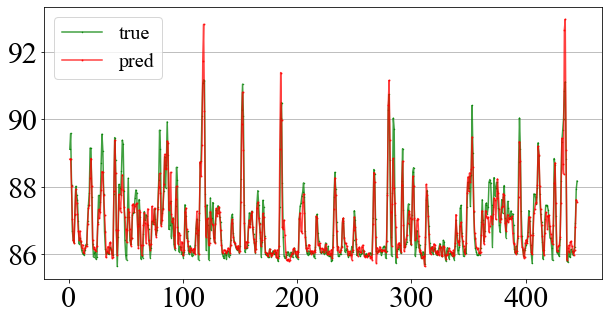

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.08329766243696213
epoch 0 : 100 ~ 200 0.004723061807453632
epoch 1
epoch 1 : 0 ~ 100 0.019801657646894455
epoch 1 : 100 ~ 200 0.0062016649171710014
epoch 2
epoch 2 : 0 ~ 100 0.013218319043517113
epoch 2 : 100 ~ 200 0.006008098367601633
epoch 3
epoch 3 : 0 ~ 100 0.010742438025772572
epoch 3 : 100 ~ 200 0.005866377614438534
epoch 4
epoch 4 : 0 ~ 100 0.009175437502563
epoch 4 : 100 ~ 200 0.005772772245109081
epoch 5
epoch 5 : 0 ~ 100 0.00794940534979105
epoch 5 : 100 ~ 200 0.005747636314481497
epoch 6
epoch 6 : 0 ~ 100 0.006858003791421652
epoch 6 : 100 ~ 200 0.005827774293720722
epoch 7
epoch 7 : 0 ~ 100 0.005914861802011728
epoch 7 : 100 ~ 200 0.00594749441370368
epoch 8
epoch 8 : 0 ~ 100 0.005761365406215191
epoch 8 : 100 ~ 200 0.005945044569671154
epoch 9
epoch 9 : 0 ~ 100 0.006563068833202124
epoch 9 : 100 ~ 200 0.005831348709762096
epoch 10
epoch 10 : 0 ~ 100 0.007169651798903942
epoch 10 : 100 ~ 200 0.00558354239910841
epoch 11
epoch 1

epoch 90
epoch 90 : 0 ~ 100 0.000993309891782701
epoch 90 : 100 ~ 200 0.0017808666452765465
epoch 91
epoch 91 : 0 ~ 100 0.0007543396204710007
epoch 91 : 100 ~ 200 0.0012765200808644295
epoch 92
epoch 92 : 0 ~ 100 0.0009177428437396884
epoch 92 : 100 ~ 200 0.001665631658397615
epoch 93
epoch 93 : 0 ~ 100 0.0006186187965795398
epoch 93 : 100 ~ 200 0.0011906186118721962
epoch 94
epoch 94 : 0 ~ 100 0.0008469157037325203
epoch 94 : 100 ~ 200 0.001698880223557353
epoch 95
epoch 95 : 0 ~ 100 0.000690113753080368
epoch 95 : 100 ~ 200 0.0011085339356213808
epoch 96
epoch 96 : 0 ~ 100 0.0007904786616563797
epoch 96 : 100 ~ 200 0.0016235103830695152
epoch 97
epoch 97 : 0 ~ 100 0.0009332422050647438
epoch 97 : 100 ~ 200 0.0009360740659758449
epoch 98
epoch 98 : 0 ~ 100 0.0006283726543188095
epoch 98 : 100 ~ 200 0.001382635091431439
epoch 99
epoch 99 : 0 ~ 100 0.0010122357634827495
epoch 99 : 100 ~ 200 0.0014322737697511911
data processing...
loading model...
predicting...
rmse: 0.4247980402549852


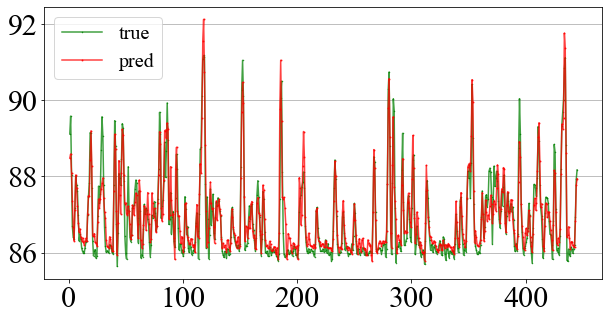

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.18506792187690735
epoch 0 : 100 ~ 200 0.011166044510900974
epoch 1
epoch 1 : 0 ~ 100 0.0517965666949749
epoch 1 : 100 ~ 200 0.00739217409864068
epoch 2
epoch 2 : 0 ~ 100 0.035123392939567566
epoch 2 : 100 ~ 200 0.0066164112649858
epoch 3
epoch 3 : 0 ~ 100 0.02982906997203827
epoch 3 : 100 ~ 200 0.006272060330957174
epoch 4
epoch 4 : 0 ~ 100 0.02599499188363552
epoch 4 : 100 ~ 200 0.00610241387039423
epoch 5
epoch 5 : 0 ~ 100 0.02205885574221611
epoch 5 : 100 ~ 200 0.006066810339689255
epoch 6
epoch 6 : 0 ~ 100 0.01690622977912426
epoch 6 : 100 ~ 200 0.006253679282963276
epoch 7
epoch 7 : 0 ~ 100 0.010759341530501842
epoch 7 : 100 ~ 200 0.006905803922563791
epoch 8
epoch 8 : 0 ~ 100 0.0076649985276162624
epoch 8 : 100 ~ 200 0.007876088842749596
epoch 9
epoch 9 : 0 ~ 100 0.007788259536027908
epoch 9 : 100 ~ 200 0.00833522342145443
epoch 10
epoch 10 : 0 ~ 100 0.008248265832662582
epoch 10 : 100 ~ 200 0.008353439159691334
epoch 11
epoch 11 : 0

epoch 89 : 100 ~ 200 0.0007808518130332232
epoch 90
epoch 90 : 0 ~ 100 0.0004618219973053783
epoch 90 : 100 ~ 200 0.0007730680517852306
epoch 91
epoch 91 : 0 ~ 100 0.0005109303165227175
epoch 91 : 100 ~ 200 0.0006060503656044602
epoch 92
epoch 92 : 0 ~ 100 0.00027644980582408607
epoch 92 : 100 ~ 200 0.0001311309461016208
epoch 93
epoch 93 : 0 ~ 100 0.0006600467604584992
epoch 93 : 100 ~ 200 0.0006416163523681462
epoch 94
epoch 94 : 0 ~ 100 0.00020631290681194514
epoch 94 : 100 ~ 200 0.002256432082504034
epoch 95
epoch 95 : 0 ~ 100 0.0010633112397044897
epoch 95 : 100 ~ 200 0.0009574340656399727
epoch 96
epoch 96 : 0 ~ 100 0.00140841503161937
epoch 96 : 100 ~ 200 0.001205655513331294
epoch 97
epoch 97 : 0 ~ 100 0.0003222804516553879
epoch 97 : 100 ~ 200 0.0006653483724221587
epoch 98
epoch 98 : 0 ~ 100 0.0003321703406982124
epoch 98 : 100 ~ 200 0.0002350218128412962
epoch 99
epoch 99 : 0 ~ 100 0.0002234824059996754
epoch 99 : 100 ~ 200 0.0001166778602055274
data processing...
loading mo

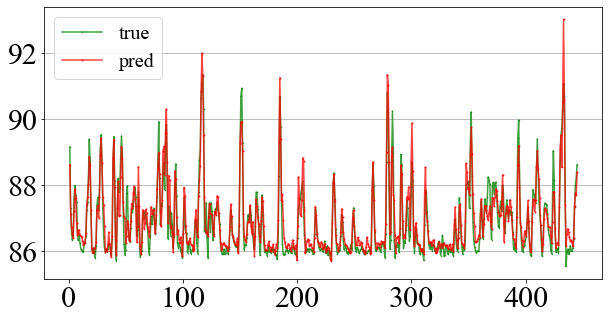

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.15417355298995972
epoch 0 : 100 ~ 200 0.007570694200694561
epoch 1
epoch 1 : 0 ~ 100 0.04516923055052757
epoch 1 : 100 ~ 200 0.007565936539322138
epoch 2
epoch 2 : 0 ~ 100 0.03409611061215401
epoch 2 : 100 ~ 200 0.007326570805162191
epoch 3
epoch 3 : 0 ~ 100 0.030212169513106346
epoch 3 : 100 ~ 200 0.007295920513570309
epoch 4
epoch 4 : 0 ~ 100 0.027644913643598557
epoch 4 : 100 ~ 200 0.00735296169295907
epoch 5
epoch 5 : 0 ~ 100 0.02495613694190979
epoch 5 : 100 ~ 200 0.00752669433131814
epoch 6
epoch 6 : 0 ~ 100 0.020802076905965805
epoch 6 : 100 ~ 200 0.008061368949711323
epoch 7
epoch 7 : 0 ~ 100 0.014870846644043922
epoch 7 : 100 ~ 200 0.00919698178768158
epoch 8
epoch 8 : 0 ~ 100 0.01157304085791111
epoch 8 : 100 ~ 200 0.009887074120342731
epoch 9
epoch 9 : 0 ~ 100 0.010698951780796051
epoch 9 : 100 ~ 200 0.009863165207207203
epoch 10
epoch 10 : 0 ~ 100 0.010278124362230301
epoch 10 : 100 ~ 200 0.00961367879062891
epoch 11
epoch 11 :

epoch 89 : 100 ~ 200 0.0002565415343269706
epoch 90
epoch 90 : 0 ~ 100 0.0033639506436884403
epoch 90 : 100 ~ 200 0.0009018206037580967
epoch 91
epoch 91 : 0 ~ 100 0.0014292702544480562
epoch 91 : 100 ~ 200 0.00021465573809109628
epoch 92
epoch 92 : 0 ~ 100 0.0029206888284534216
epoch 92 : 100 ~ 200 0.0011277468875050545
epoch 93
epoch 93 : 0 ~ 100 0.0013164619449526072
epoch 93 : 100 ~ 200 0.0005486393347382545
epoch 94
epoch 94 : 0 ~ 100 0.0013954044552519917
epoch 94 : 100 ~ 200 0.0013209495227783918
epoch 95
epoch 95 : 0 ~ 100 0.0007328465580940247
epoch 95 : 100 ~ 200 7.831581024220213e-05
epoch 96
epoch 96 : 0 ~ 100 0.0008997311815619469
epoch 96 : 100 ~ 200 0.0007510517025366426
epoch 97
epoch 97 : 0 ~ 100 0.0011203770991414785
epoch 97 : 100 ~ 200 0.00010259998089168221
epoch 98
epoch 98 : 0 ~ 100 0.0017596862744539976
epoch 98 : 100 ~ 200 0.0007420183392241597
epoch 99
epoch 99 : 0 ~ 100 0.0012500722659751773
epoch 99 : 100 ~ 200 7.489303243346512e-05
data processing...
loadin

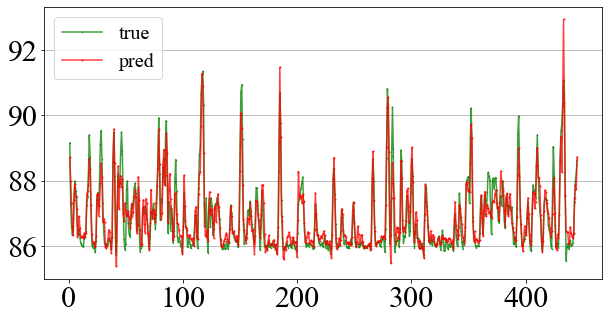

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.17808184027671814
epoch 0 : 100 ~ 200 0.01186261884868145
epoch 1
epoch 1 : 0 ~ 100 0.04152708500623703
epoch 1 : 100 ~ 200 0.008661341853439808
epoch 2
epoch 2 : 0 ~ 100 0.03254776820540428
epoch 2 : 100 ~ 200 0.009072234854102135
epoch 3
epoch 3 : 0 ~ 100 0.029240529984235764
epoch 3 : 100 ~ 200 0.009495359845459461
epoch 4
epoch 4 : 0 ~ 100 0.027014311403036118
epoch 4 : 100 ~ 200 0.009882865473628044
epoch 5
epoch 5 : 0 ~ 100 0.024723580107092857
epoch 5 : 100 ~ 200 0.010305073112249374
epoch 6
epoch 6 : 0 ~ 100 0.021224241703748703
epoch 6 : 100 ~ 200 0.011012183502316475
epoch 7
epoch 7 : 0 ~ 100 0.015593836084008217
epoch 7 : 100 ~ 200 0.012134983204305172
epoch 8
epoch 8 : 0 ~ 100 0.010714407078921795
epoch 8 : 100 ~ 200 0.013066863641142845
epoch 9
epoch 9 : 0 ~ 100 0.009177161380648613
epoch 9 : 100 ~ 200 0.013313986361026764
epoch 10
epoch 10 : 0 ~ 100 0.008709686808288097
epoch 10 : 100 ~ 200 0.01323609333485365
epoch 11
epoch 

epoch 89 : 100 ~ 200 0.0007913337904028594
epoch 90
epoch 90 : 0 ~ 100 0.010109581053256989
epoch 90 : 100 ~ 200 0.0013015985023230314
epoch 91
epoch 91 : 0 ~ 100 0.00944687519222498
epoch 91 : 100 ~ 200 0.00242940173484385
epoch 92
epoch 92 : 0 ~ 100 0.0032969475723803043
epoch 92 : 100 ~ 200 0.0001618987589608878
epoch 93
epoch 93 : 0 ~ 100 0.0003621183568611741
epoch 93 : 100 ~ 200 0.000252530473517254
epoch 94
epoch 94 : 0 ~ 100 0.000667484593577683
epoch 94 : 100 ~ 200 0.0002749130944721401
epoch 95
epoch 95 : 0 ~ 100 0.00024464254966005683
epoch 95 : 100 ~ 200 0.0012662869412451982
epoch 96
epoch 96 : 0 ~ 100 0.00018919623107649386
epoch 96 : 100 ~ 200 7.671456842217594e-05
epoch 97
epoch 97 : 0 ~ 100 0.00021226142416708171
epoch 97 : 100 ~ 200 0.0004211605992168188
epoch 98
epoch 98 : 0 ~ 100 0.002737605944275856
epoch 98 : 100 ~ 200 0.0003516875149216503
epoch 99
epoch 99 : 0 ~ 100 0.011482961475849152
epoch 99 : 100 ~ 200 0.0005564343882724643
data processing...
loading model.

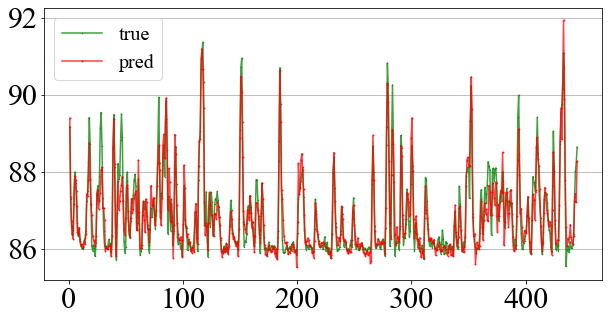

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.13793356716632843
epoch 0 : 100 ~ 200 0.006759228650480509
epoch 1
epoch 1 : 0 ~ 100 0.03703881800174713
epoch 1 : 100 ~ 200 0.0071273730136454105
epoch 2
epoch 2 : 0 ~ 100 0.028111398220062256
epoch 2 : 100 ~ 200 0.008174054324626923
epoch 3
epoch 3 : 0 ~ 100 0.024369481950998306
epoch 3 : 100 ~ 200 0.008829599246382713
epoch 4
epoch 4 : 0 ~ 100 0.021009549498558044
epoch 4 : 100 ~ 200 0.00945849996060133
epoch 5
epoch 5 : 0 ~ 100 0.016703493893146515
epoch 5 : 100 ~ 200 0.010114754550158978
epoch 6
epoch 6 : 0 ~ 100 0.010947415605187416
epoch 6 : 100 ~ 200 0.01089291088283062
epoch 7
epoch 7 : 0 ~ 100 0.006744903977960348
epoch 7 : 100 ~ 200 0.011717094108462334
epoch 8
epoch 8 : 0 ~ 100 0.006000933237373829
epoch 8 : 100 ~ 200 0.01209430955350399
epoch 9
epoch 9 : 0 ~ 100 0.005747556686401367
epoch 9 : 100 ~ 200 0.012232717126607895
epoch 10
epoch 10 : 0 ~ 100 0.005370519123971462
epoch 10 : 100 ~ 200 0.012362321838736534
epoch 11
epoch

epoch 89 : 100 ~ 200 0.00011038778757210821
epoch 90
epoch 90 : 0 ~ 100 3.616388494265266e-05
epoch 90 : 100 ~ 200 0.00011022600665455684
epoch 91
epoch 91 : 0 ~ 100 0.00029577352688647807
epoch 91 : 100 ~ 200 0.00017147591279353946
epoch 92
epoch 92 : 0 ~ 100 0.003997987601906061
epoch 92 : 100 ~ 200 0.0011298786848783493
epoch 93
epoch 93 : 0 ~ 100 0.003038110677152872
epoch 93 : 100 ~ 200 0.00037300187977962196
epoch 94
epoch 94 : 0 ~ 100 0.0003497172729112208
epoch 94 : 100 ~ 200 0.0003372799255885184
epoch 95
epoch 95 : 0 ~ 100 0.0009727953001856804
epoch 95 : 100 ~ 200 0.0008701583137735724
epoch 96
epoch 96 : 0 ~ 100 0.0009921605233103037
epoch 96 : 100 ~ 200 0.0007249837508425117
epoch 97
epoch 97 : 0 ~ 100 0.0007912081782706082
epoch 97 : 100 ~ 200 9.20720849535428e-05
epoch 98
epoch 98 : 0 ~ 100 0.0008717870223335922
epoch 98 : 100 ~ 200 0.00043040746822953224
epoch 99
epoch 99 : 0 ~ 100 0.001958574168384075
epoch 99 : 100 ~ 200 0.00010837992886081338
data processing...
loadi

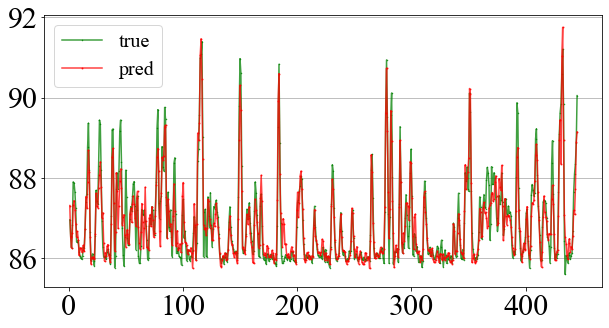

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.07322987914085388
epoch 0 : 100 ~ 200 0.006877857260406017
epoch 1
epoch 1 : 0 ~ 100 0.02626621723175049
epoch 1 : 100 ~ 200 0.006666176952421665
epoch 2
epoch 2 : 0 ~ 100 0.02240932546555996
epoch 2 : 100 ~ 200 0.007045721169561148
epoch 3
epoch 3 : 0 ~ 100 0.020841384306550026
epoch 3 : 100 ~ 200 0.007422336842864752
epoch 4
epoch 4 : 0 ~ 100 0.019294053316116333
epoch 4 : 100 ~ 200 0.007844326086342335
epoch 5
epoch 5 : 0 ~ 100 0.01668849214911461
epoch 5 : 100 ~ 200 0.008363304659724236
epoch 6
epoch 6 : 0 ~ 100 0.011853225529193878
epoch 6 : 100 ~ 200 0.009139475412666798
epoch 7
epoch 7 : 0 ~ 100 0.006548016332089901
epoch 7 : 100 ~ 200 0.010010579600930214
epoch 8
epoch 8 : 0 ~ 100 0.0045961723662912846
epoch 8 : 100 ~ 200 0.010401449166238308
epoch 9
epoch 9 : 0 ~ 100 0.0035955682396888733
epoch 9 : 100 ~ 200 0.010521100834012032
epoch 10
epoch 10 : 0 ~ 100 0.0028300764970481396
epoch 10 : 100 ~ 200 0.01055263914167881
epoch 11
epo

epoch 89 : 0 ~ 100 0.0007683384465053678
epoch 89 : 100 ~ 200 0.0006791038322262466
epoch 90
epoch 90 : 0 ~ 100 0.0016604519914835691
epoch 90 : 100 ~ 200 0.0006403891602531075
epoch 91
epoch 91 : 0 ~ 100 0.0013297306140884757
epoch 91 : 100 ~ 200 0.0007670161430723965
epoch 92
epoch 92 : 0 ~ 100 0.002073974348604679
epoch 92 : 100 ~ 200 7.42577321943827e-05
epoch 93
epoch 93 : 0 ~ 100 0.001994726713746786
epoch 93 : 100 ~ 200 0.0002770935243461281
epoch 94
epoch 94 : 0 ~ 100 0.0007582436082884669
epoch 94 : 100 ~ 200 0.00020970602054148912
epoch 95
epoch 95 : 0 ~ 100 0.0003137407184112817
epoch 95 : 100 ~ 200 5.2430801588343456e-05
epoch 96
epoch 96 : 0 ~ 100 0.0006603426299989223
epoch 96 : 100 ~ 200 0.0002719979383982718
epoch 97
epoch 97 : 0 ~ 100 0.000435719673987478
epoch 97 : 100 ~ 200 0.0004989576409570873
epoch 98
epoch 98 : 0 ~ 100 0.0011490123579278588
epoch 98 : 100 ~ 200 0.0006218464695848525
epoch 99
epoch 99 : 0 ~ 100 0.0026785745285451412
epoch 99 : 100 ~ 200 0.00075298

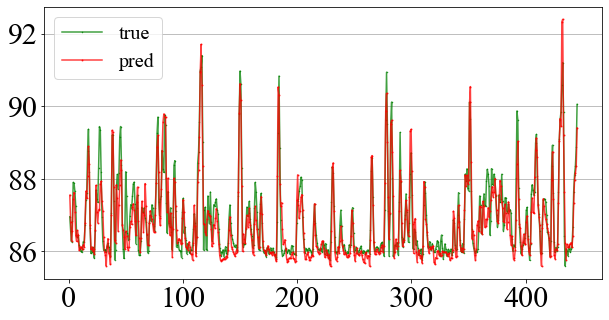

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.006268943659961224
epoch 0 : 100 ~ 200 0.0013152677565813065
epoch 1
epoch 1 : 0 ~ 100 0.0032957252115011215
epoch 1 : 100 ~ 200 0.0034330226480960846
epoch 2
epoch 2 : 0 ~ 100 0.002145812613889575
epoch 2 : 100 ~ 200 0.004308870527893305
epoch 3
epoch 3 : 0 ~ 100 0.0023854230530560017
epoch 3 : 100 ~ 200 0.004854233469814062
epoch 4
epoch 4 : 0 ~ 100 0.00271957041695714
epoch 4 : 100 ~ 200 0.00515875406563282
epoch 5
epoch 5 : 0 ~ 100 0.0030774374026805162
epoch 5 : 100 ~ 200 0.005211364943534136
epoch 6
epoch 6 : 0 ~ 100 0.0035186384338885546
epoch 6 : 100 ~ 200 0.005108459386974573
epoch 7
epoch 7 : 0 ~ 100 0.004146345891058445
epoch 7 : 100 ~ 200 0.004999897442758083
epoch 8
epoch 8 : 0 ~ 100 0.004496566951274872
epoch 8 : 100 ~ 200 0.004830640275031328
epoch 9
epoch 9 : 0 ~ 100 0.004141222219914198
epoch 9 : 100 ~ 200 0.004624759778380394
epoch 10
epoch 10 : 0 ~ 100 0.0036461055278778076
epoch 10 : 100 ~ 200 0.004474763758480549
epoch

epoch 89 : 0 ~ 100 0.0023009527940303087
epoch 89 : 100 ~ 200 0.0003141679335385561
epoch 90
epoch 90 : 0 ~ 100 0.000373672490241006
epoch 90 : 100 ~ 200 0.00021167806698940694
epoch 91
epoch 91 : 0 ~ 100 0.0004207836464047432
epoch 91 : 100 ~ 200 0.00017214972467627376
epoch 92
epoch 92 : 0 ~ 100 0.0002483916759956628
epoch 92 : 100 ~ 200 0.00018013690714724362
epoch 93
epoch 93 : 0 ~ 100 0.00021257527987472713
epoch 93 : 100 ~ 200 0.0002470962062943727
epoch 94
epoch 94 : 0 ~ 100 0.00038326915819197893
epoch 94 : 100 ~ 200 0.000211473714443855
epoch 95
epoch 95 : 0 ~ 100 0.00213375361636281
epoch 95 : 100 ~ 200 0.00014696011203341186
epoch 96
epoch 96 : 0 ~ 100 0.002859979635104537
epoch 96 : 100 ~ 200 0.0017923042178153992
epoch 97
epoch 97 : 0 ~ 100 0.00145420478656888
epoch 97 : 100 ~ 200 3.2873856980586424e-05
epoch 98
epoch 98 : 0 ~ 100 0.0031079226173460484
epoch 98 : 100 ~ 200 0.0003905162448063493
epoch 99
epoch 99 : 0 ~ 100 0.0009258821373805404
epoch 99 : 100 ~ 200 0.000452

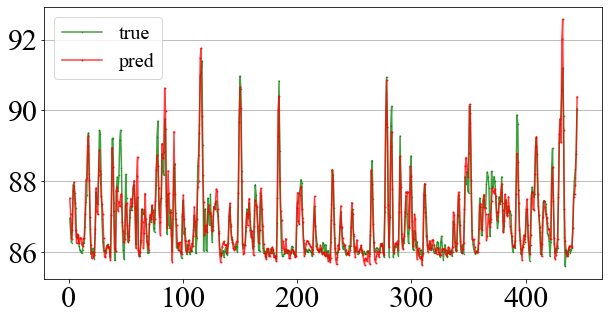

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.006889043841511011
epoch 0 : 100 ~ 200 0.005450532305985689
epoch 1
epoch 1 : 0 ~ 100 0.003483989043161273
epoch 1 : 100 ~ 200 0.0030736462213099003
epoch 2
epoch 2 : 0 ~ 100 0.0025498399045318365
epoch 2 : 100 ~ 200 0.003561687422916293
epoch 3
epoch 3 : 0 ~ 100 0.002193080261349678
epoch 3 : 100 ~ 200 0.003931339364498854
epoch 4
epoch 4 : 0 ~ 100 0.0018916809931397438
epoch 4 : 100 ~ 200 0.0043214415200054646
epoch 5
epoch 5 : 0 ~ 100 0.0015985540812835097
epoch 5 : 100 ~ 200 0.004701296798884869
epoch 6
epoch 6 : 0 ~ 100 0.0013283005682751536
epoch 6 : 100 ~ 200 0.004945383407175541
epoch 7
epoch 7 : 0 ~ 100 0.0011437773937359452
epoch 7 : 100 ~ 200 0.004883551970124245
epoch 8
epoch 8 : 0 ~ 100 0.0011438366491347551
epoch 8 : 100 ~ 200 0.004599329084157944
epoch 9
epoch 9 : 0 ~ 100 0.0012650794815272093
epoch 9 : 100 ~ 200 0.0043562655337154865
epoch 10
epoch 10 : 0 ~ 100 0.0012479377910494804
epoch 10 : 100 ~ 200 0.00419754208996892


epoch 88 : 100 ~ 200 0.0010698994155973196
epoch 89
epoch 89 : 0 ~ 100 0.00011570988863240927
epoch 89 : 100 ~ 200 0.0009664841927587986
epoch 90
epoch 90 : 0 ~ 100 0.0005382613162510097
epoch 90 : 100 ~ 200 0.0002607643255032599
epoch 91
epoch 91 : 0 ~ 100 0.0017497371882200241
epoch 91 : 100 ~ 200 0.0022864947095513344
epoch 92
epoch 92 : 0 ~ 100 0.00097325025126338
epoch 92 : 100 ~ 200 0.002472285646945238
epoch 93
epoch 93 : 0 ~ 100 0.0012002323055639863
epoch 93 : 100 ~ 200 0.0005844990955665708
epoch 94
epoch 94 : 0 ~ 100 0.00026284181512892246
epoch 94 : 100 ~ 200 0.0015171096893027425
epoch 95
epoch 95 : 0 ~ 100 0.0009807813912630081
epoch 95 : 100 ~ 200 0.0011024940758943558
epoch 96
epoch 96 : 0 ~ 100 0.00016685156151652336
epoch 96 : 100 ~ 200 0.0010844257194548845
epoch 97
epoch 97 : 0 ~ 100 0.00045605204650200903
epoch 97 : 100 ~ 200 0.0010593680199235678
epoch 98
epoch 98 : 0 ~ 100 0.0005738798645325005
epoch 98 : 100 ~ 200 0.00078597292304039
epoch 99
epoch 99 : 0 ~ 100 

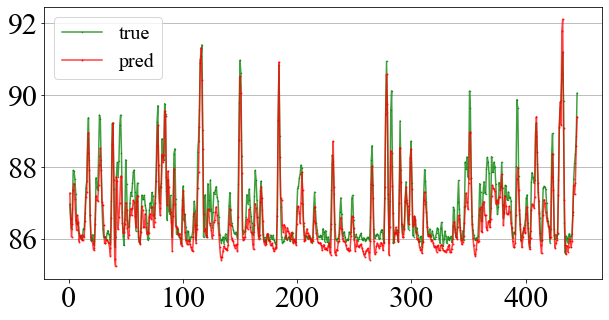

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.006996782962232828
epoch 0 : 100 ~ 200 0.008338813669979572
epoch 1
epoch 1 : 0 ~ 100 0.0036552585661411285
epoch 1 : 100 ~ 200 0.0038647442124783993
epoch 2
epoch 2 : 0 ~ 100 0.001989764627069235
epoch 2 : 100 ~ 200 0.0029508161824196577
epoch 3
epoch 3 : 0 ~ 100 0.0016640573740005493
epoch 3 : 100 ~ 200 0.0025026563089340925
epoch 4
epoch 4 : 0 ~ 100 0.0014695320278406143
epoch 4 : 100 ~ 200 0.002184169599786401
epoch 5
epoch 5 : 0 ~ 100 0.0012457359116524458
epoch 5 : 100 ~ 200 0.0019514072919264436
epoch 6
epoch 6 : 0 ~ 100 0.0010327465133741498
epoch 6 : 100 ~ 200 0.0018552333349362016
epoch 7
epoch 7 : 0 ~ 100 0.0011180767323821783
epoch 7 : 100 ~ 200 0.0018641154747456312
epoch 8
epoch 8 : 0 ~ 100 0.001386643503792584
epoch 8 : 100 ~ 200 0.0018266967963427305
epoch 9
epoch 9 : 0 ~ 100 0.0015374848153442144
epoch 9 : 100 ~ 200 0.0017962545389309525
epoch 10
epoch 10 : 0 ~ 100 0.0015687458217144012
epoch 10 : 100 ~ 200 0.0017964238068

epoch 88 : 100 ~ 200 0.0001694991224212572
epoch 89
epoch 89 : 0 ~ 100 0.00017502953414805233
epoch 89 : 100 ~ 200 0.0003375168307684362
epoch 90
epoch 90 : 0 ~ 100 0.00022991225705482066
epoch 90 : 100 ~ 200 0.00025908611132763326
epoch 91
epoch 91 : 0 ~ 100 0.0003449032665230334
epoch 91 : 100 ~ 200 0.00023366432287730277
epoch 92
epoch 92 : 0 ~ 100 0.0001334553526248783
epoch 92 : 100 ~ 200 0.00029014339088462293
epoch 93
epoch 93 : 0 ~ 100 0.0009262933162972331
epoch 93 : 100 ~ 200 0.00042424164712429047
epoch 94
epoch 94 : 0 ~ 100 0.00022916775196790695
epoch 94 : 100 ~ 200 0.000378078140784055
epoch 95
epoch 95 : 0 ~ 100 0.0008309872937388718
epoch 95 : 100 ~ 200 0.00019262063142377883
epoch 96
epoch 96 : 0 ~ 100 0.00024095662229228765
epoch 96 : 100 ~ 200 0.00010777490388136357
epoch 97
epoch 97 : 0 ~ 100 0.0003272980102337897
epoch 97 : 100 ~ 200 0.0002436119830235839
epoch 98
epoch 98 : 0 ~ 100 0.0002687534724827856
epoch 98 : 100 ~ 200 0.000603055173996836
epoch 99
epoch 99 :

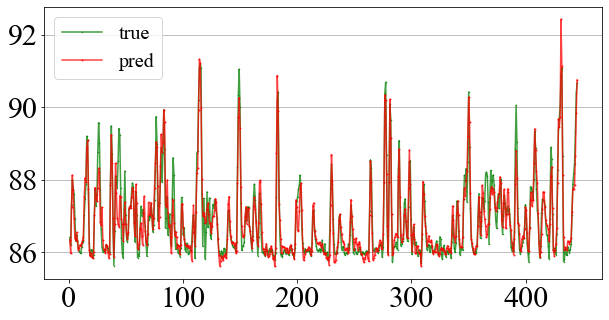

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.003837813390418887
epoch 0 : 100 ~ 200 0.03992072865366936
epoch 1
epoch 1 : 0 ~ 100 0.0026762562338262796
epoch 1 : 100 ~ 200 0.025525908917188644
epoch 2
epoch 2 : 0 ~ 100 0.002429618965834379
epoch 2 : 100 ~ 200 0.022836891934275627
epoch 3
epoch 3 : 0 ~ 100 0.0022802643943578005
epoch 3 : 100 ~ 200 0.02073046937584877
epoch 4
epoch 4 : 0 ~ 100 0.002079813275486231
epoch 4 : 100 ~ 200 0.018543681129813194
epoch 5
epoch 5 : 0 ~ 100 0.0017716661095619202
epoch 5 : 100 ~ 200 0.015862232074141502
epoch 6
epoch 6 : 0 ~ 100 0.0014358797343447804
epoch 6 : 100 ~ 200 0.012823479250073433
epoch 7
epoch 7 : 0 ~ 100 0.001315880217589438
epoch 7 : 100 ~ 200 0.010187352076172829
epoch 8
epoch 8 : 0 ~ 100 0.0013527192641049623
epoch 8 : 100 ~ 200 0.00816179346293211
epoch 9
epoch 9 : 0 ~ 100 0.0014978012768551707
epoch 9 : 100 ~ 200 0.006814025342464447
epoch 10
epoch 10 : 0 ~ 100 0.0017030216986313462
epoch 10 : 100 ~ 200 0.0059136562049388885
epoch

epoch 88 : 100 ~ 200 0.00031368184136226773
epoch 89
epoch 89 : 0 ~ 100 0.00019622012041509151
epoch 89 : 100 ~ 200 0.0007128337165340781
epoch 90
epoch 90 : 0 ~ 100 0.00020853635214734823
epoch 90 : 100 ~ 200 0.00021213837317191064
epoch 91
epoch 91 : 0 ~ 100 0.00048358869389630854
epoch 91 : 100 ~ 200 0.0003675110638141632
epoch 92
epoch 92 : 0 ~ 100 0.00021837007079739124
epoch 92 : 100 ~ 200 0.0006826258613727987
epoch 93
epoch 93 : 0 ~ 100 0.00039259655750356615
epoch 93 : 100 ~ 200 0.0003053311083931476
epoch 94
epoch 94 : 0 ~ 100 0.00011929331958526745
epoch 94 : 100 ~ 200 0.0002563124580774456
epoch 95
epoch 95 : 0 ~ 100 0.00011353276204317808
epoch 95 : 100 ~ 200 0.001273607020266354
epoch 96
epoch 96 : 0 ~ 100 0.00031352677615359426
epoch 96 : 100 ~ 200 0.0008734812145121396
epoch 97
epoch 97 : 0 ~ 100 0.0004173198249191046
epoch 97 : 100 ~ 200 0.0005116410320624709
epoch 98
epoch 98 : 0 ~ 100 0.00018139032181352377
epoch 98 : 100 ~ 200 0.0004671616479754448
epoch 99
epoch 99

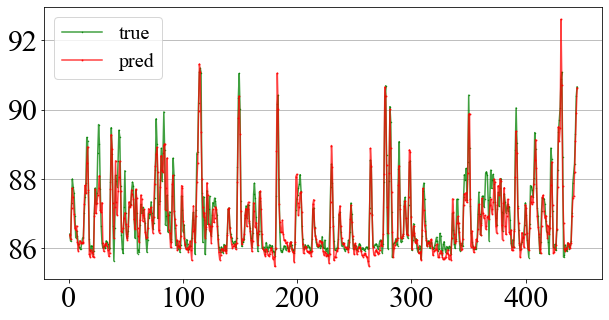

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.009123675525188446
epoch 0 : 100 ~ 200 0.08354891836643219
epoch 1
epoch 1 : 0 ~ 100 0.0033457495737820864
epoch 1 : 100 ~ 200 0.049550026655197144
epoch 2
epoch 2 : 0 ~ 100 0.0028666341677308083
epoch 2 : 100 ~ 200 0.04592740908265114
epoch 3
epoch 3 : 0 ~ 100 0.002614301862195134
epoch 3 : 100 ~ 200 0.042943455278873444
epoch 4
epoch 4 : 0 ~ 100 0.0024328746367245913
epoch 4 : 100 ~ 200 0.040357887744903564
epoch 5
epoch 5 : 0 ~ 100 0.002257253509014845
epoch 5 : 100 ~ 200 0.03780912607908249
epoch 6
epoch 6 : 0 ~ 100 0.0020701102912425995
epoch 6 : 100 ~ 200 0.0348474457859993
epoch 7
epoch 7 : 0 ~ 100 0.0018732044845819473
epoch 7 : 100 ~ 200 0.03127136081457138
epoch 8
epoch 8 : 0 ~ 100 0.0016440090257674456
epoch 8 : 100 ~ 200 0.027684936299920082
epoch 9
epoch 9 : 0 ~ 100 0.0015126046491786838
epoch 9 : 100 ~ 200 0.025004252791404724
epoch 10
epoch 10 : 0 ~ 100 0.0015828696778044105
epoch 10 : 100 ~ 200 0.023404177278280258
epoch 11

epoch 89 : 0 ~ 100 0.0001599058450665325
epoch 89 : 100 ~ 200 0.0007196106598712504
epoch 90
epoch 90 : 0 ~ 100 0.00023180324933491647
epoch 90 : 100 ~ 200 0.0006449483335018158
epoch 91
epoch 91 : 0 ~ 100 0.00015910493675619364
epoch 91 : 100 ~ 200 0.0006987376837059855
epoch 92
epoch 92 : 0 ~ 100 0.0007470628479495645
epoch 92 : 100 ~ 200 0.00038267060881480575
epoch 93
epoch 93 : 0 ~ 100 8.762683137319982e-05
epoch 93 : 100 ~ 200 0.002604325767606497
epoch 94
epoch 94 : 0 ~ 100 0.0003823713632300496
epoch 94 : 100 ~ 200 0.0005844536935910583
epoch 95
epoch 95 : 0 ~ 100 0.0002813193423207849
epoch 95 : 100 ~ 200 0.00042176758870482445
epoch 96
epoch 96 : 0 ~ 100 0.0004183469864074141
epoch 96 : 100 ~ 200 0.0009160799672827125
epoch 97
epoch 97 : 0 ~ 100 0.00022945471573621035
epoch 97 : 100 ~ 200 0.0003910500090569258
epoch 98
epoch 98 : 0 ~ 100 0.000256051542237401
epoch 98 : 100 ~ 200 0.00016207541921176016
epoch 99
epoch 99 : 0 ~ 100 0.00010310478683095425
epoch 99 : 100 ~ 200 0.0

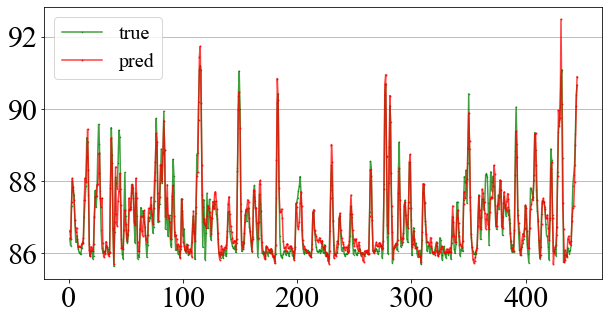

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.009724276140332222
epoch 0 : 100 ~ 200 0.0980134829878807
epoch 1
epoch 1 : 0 ~ 100 0.005162467248737812
epoch 1 : 100 ~ 200 0.061201661825180054
epoch 2
epoch 2 : 0 ~ 100 0.004764316137880087
epoch 2 : 100 ~ 200 0.05733555555343628
epoch 3
epoch 3 : 0 ~ 100 0.004419021308422089
epoch 3 : 100 ~ 200 0.054060231894254684
epoch 4
epoch 4 : 0 ~ 100 0.0040532564744353294
epoch 4 : 100 ~ 200 0.05084868520498276
epoch 5
epoch 5 : 0 ~ 100 0.003649325342848897
epoch 5 : 100 ~ 200 0.04710669070482254
epoch 6
epoch 6 : 0 ~ 100 0.003250265959650278
epoch 6 : 100 ~ 200 0.04228360578417778
epoch 7
epoch 7 : 0 ~ 100 0.0030012994538992643
epoch 7 : 100 ~ 200 0.03667169809341431
epoch 8
epoch 8 : 0 ~ 100 0.0029632376972585917
epoch 8 : 100 ~ 200 0.031960628926754
epoch 9
epoch 9 : 0 ~ 100 0.002940280130133033
epoch 9 : 100 ~ 200 0.028864193707704544
epoch 10
epoch 10 : 0 ~ 100 0.002976336982101202
epoch 10 : 100 ~ 200 0.0265769362449646
epoch 11
epoch 11 :

epoch 89 : 0 ~ 100 0.00030399742536246777
epoch 89 : 100 ~ 200 0.0005791636067442596
epoch 90
epoch 90 : 0 ~ 100 0.00034371187211945653
epoch 90 : 100 ~ 200 0.0011308707762509584
epoch 91
epoch 91 : 0 ~ 100 0.00018609427206683904
epoch 91 : 100 ~ 200 0.00034634681651368737
epoch 92
epoch 92 : 0 ~ 100 0.00012510707892943174
epoch 92 : 100 ~ 200 0.001900367089547217
epoch 93
epoch 93 : 0 ~ 100 0.00025702404673211277
epoch 93 : 100 ~ 200 0.0014050495810806751
epoch 94
epoch 94 : 0 ~ 100 0.0005479740793816745
epoch 94 : 100 ~ 200 0.0014044499257579446
epoch 95
epoch 95 : 0 ~ 100 9.81678967946209e-05
epoch 95 : 100 ~ 200 0.0002795577747747302
epoch 96
epoch 96 : 0 ~ 100 0.00037221895763650537
epoch 96 : 100 ~ 200 0.0003046490019187331
epoch 97
epoch 97 : 0 ~ 100 0.0001281508302781731
epoch 97 : 100 ~ 200 0.0005314541049301624
epoch 98
epoch 98 : 0 ~ 100 0.00027203731588087976
epoch 98 : 100 ~ 200 0.0007786381174810231
epoch 99
epoch 99 : 0 ~ 100 0.0013413637643679976
epoch 99 : 100 ~ 200 0.

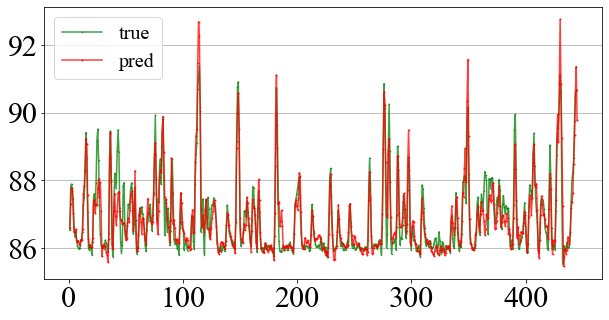

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.008755934424698353
epoch 0 : 100 ~ 200 0.0954512506723404
epoch 1
epoch 1 : 0 ~ 100 0.0041727349162101746
epoch 1 : 100 ~ 200 0.06001656502485275
epoch 2
epoch 2 : 0 ~ 100 0.0044683655723929405
epoch 2 : 100 ~ 200 0.05557060241699219
epoch 3
epoch 3 : 0 ~ 100 0.0042296466417610645
epoch 3 : 100 ~ 200 0.052006762474775314
epoch 4
epoch 4 : 0 ~ 100 0.003935875836759806
epoch 4 : 100 ~ 200 0.04865395277738571
epoch 5
epoch 5 : 0 ~ 100 0.003607130143791437
epoch 5 : 100 ~ 200 0.04477753862738609
epoch 6
epoch 6 : 0 ~ 100 0.0033625513315200806
epoch 6 : 100 ~ 200 0.039698805660009384
epoch 7
epoch 7 : 0 ~ 100 0.003425362054258585
epoch 7 : 100 ~ 200 0.03409590944647789
epoch 8
epoch 8 : 0 ~ 100 0.0036077748518437147
epoch 8 : 100 ~ 200 0.03005780652165413
epoch 9
epoch 9 : 0 ~ 100 0.003795285476371646
epoch 9 : 100 ~ 200 0.02746615931391716
epoch 10
epoch 10 : 0 ~ 100 0.003964523784816265
epoch 10 : 100 ~ 200 0.025622382760047913
epoch 11
epoch

epoch 89 : 0 ~ 100 0.0003080138412769884
epoch 89 : 100 ~ 200 0.0004540398658718914
epoch 90
epoch 90 : 0 ~ 100 0.0001398670137859881
epoch 90 : 100 ~ 200 0.0006813722429797053
epoch 91
epoch 91 : 0 ~ 100 0.00012611350393854082
epoch 91 : 100 ~ 200 1.0634283171384595e-05
epoch 92
epoch 92 : 0 ~ 100 2.773477535811253e-05
epoch 92 : 100 ~ 200 0.00030152424005791545
epoch 93
epoch 93 : 0 ~ 100 0.00042603444308042526
epoch 93 : 100 ~ 200 0.0008802707307040691
epoch 94
epoch 94 : 0 ~ 100 0.0014806896215304732
epoch 94 : 100 ~ 200 0.0010005782824009657
epoch 95
epoch 95 : 0 ~ 100 0.0006865320028737187
epoch 95 : 100 ~ 200 0.0012994103599339724
epoch 96
epoch 96 : 0 ~ 100 0.00030441308626905084
epoch 96 : 100 ~ 200 0.0006397691322490573
epoch 97
epoch 97 : 0 ~ 100 0.00012892633094452322
epoch 97 : 100 ~ 200 0.00015133785200305283
epoch 98
epoch 98 : 0 ~ 100 0.00041903479723259807
epoch 98 : 100 ~ 200 0.00036444031866267323
epoch 99
epoch 99 : 0 ~ 100 0.0013944475213065743
epoch 99 : 100 ~ 200

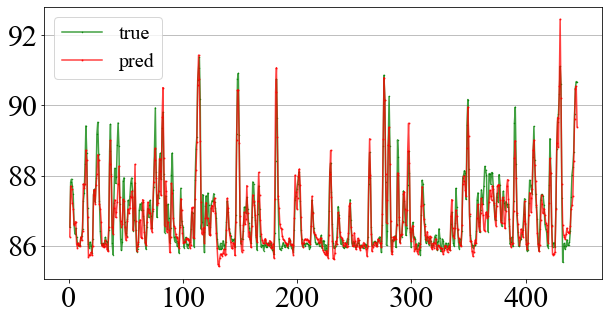

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.004260094836354256
epoch 0 : 100 ~ 200 0.06843897700309753
epoch 1
epoch 1 : 0 ~ 100 0.004008044488728046
epoch 1 : 100 ~ 200 0.05678223446011543
epoch 2
epoch 2 : 0 ~ 100 0.003932329826056957
epoch 2 : 100 ~ 200 0.05344148725271225
epoch 3
epoch 3 : 0 ~ 100 0.003665585769340396
epoch 3 : 100 ~ 200 0.05072806030511856
epoch 4
epoch 4 : 0 ~ 100 0.0033336845226585865
epoch 4 : 100 ~ 200 0.04805944859981537
epoch 5
epoch 5 : 0 ~ 100 0.002918429672718048
epoch 5 : 100 ~ 200 0.04468156024813652
epoch 6
epoch 6 : 0 ~ 100 0.0024771715980023146
epoch 6 : 100 ~ 200 0.039862681180238724
epoch 7
epoch 7 : 0 ~ 100 0.002293985104188323
epoch 7 : 100 ~ 200 0.03398967534303665
epoch 8
epoch 8 : 0 ~ 100 0.0024215858429670334
epoch 8 : 100 ~ 200 0.02886934019625187
epoch 9
epoch 9 : 0 ~ 100 0.0023636440746486187
epoch 9 : 100 ~ 200 0.02543829381465912
epoch 10
epoch 10 : 0 ~ 100 0.002363675506785512
epoch 10 : 100 ~ 200 0.02300429344177246
epoch 11
epoch 1

epoch 89 : 0 ~ 100 5.5769120081095025e-05
epoch 89 : 100 ~ 200 0.005438690539449453
epoch 90
epoch 90 : 0 ~ 100 0.00018015061505138874
epoch 90 : 100 ~ 200 0.0017386435065418482
epoch 91
epoch 91 : 0 ~ 100 3.4332868381170556e-05
epoch 91 : 100 ~ 200 0.0006101736216805875
epoch 92
epoch 92 : 0 ~ 100 9.105914796236902e-05
epoch 92 : 100 ~ 200 0.0008894270285964012
epoch 93
epoch 93 : 0 ~ 100 0.0007023030775599182
epoch 93 : 100 ~ 200 0.00032565672881901264
epoch 94
epoch 94 : 0 ~ 100 0.00013746645709034055
epoch 94 : 100 ~ 200 0.0009569269604980946
epoch 95
epoch 95 : 0 ~ 100 0.0001844546350184828
epoch 95 : 100 ~ 200 0.00028551084687933326
epoch 96
epoch 96 : 0 ~ 100 0.00013191673497203737
epoch 96 : 100 ~ 200 0.002145120408385992
epoch 97
epoch 97 : 0 ~ 100 0.00015231069119181484
epoch 97 : 100 ~ 200 0.002050040289759636
epoch 98
epoch 98 : 0 ~ 100 0.00032859155908226967
epoch 98 : 100 ~ 200 0.0002923451247625053
epoch 99
epoch 99 : 0 ~ 100 0.0001414023427059874
epoch 99 : 100 ~ 200 0.

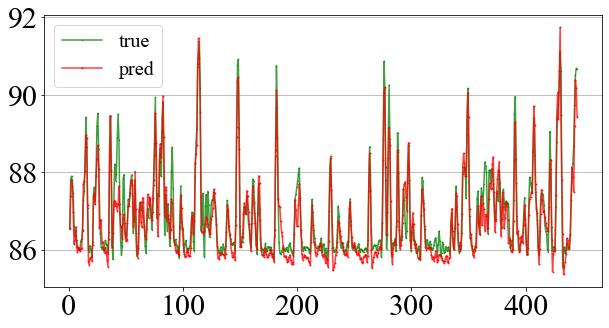

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.005346070043742657
epoch 0 : 100 ~ 200 0.03691933676600456
epoch 1
epoch 1 : 0 ~ 100 0.002481588162481785
epoch 1 : 100 ~ 200 0.034158267080783844
epoch 2
epoch 2 : 0 ~ 100 0.0026104426942765713
epoch 2 : 100 ~ 200 0.03260593116283417
epoch 3
epoch 3 : 0 ~ 100 0.0023607811890542507
epoch 3 : 100 ~ 200 0.031034111976623535
epoch 4
epoch 4 : 0 ~ 100 0.0020419482607394457
epoch 4 : 100 ~ 200 0.029273588210344315
epoch 5
epoch 5 : 0 ~ 100 0.0016791740199550986
epoch 5 : 100 ~ 200 0.027128096669912338
epoch 6
epoch 6 : 0 ~ 100 0.0013841765467077494
epoch 6 : 100 ~ 200 0.024652035906910896
epoch 7
epoch 7 : 0 ~ 100 0.0014096125960350037
epoch 7 : 100 ~ 200 0.022074367851018906
epoch 8
epoch 8 : 0 ~ 100 0.001701561501249671
epoch 8 : 100 ~ 200 0.019767992198467255
epoch 9
epoch 9 : 0 ~ 100 0.0019205615390092134
epoch 9 : 100 ~ 200 0.0180632583796978
epoch 10
epoch 10 : 0 ~ 100 0.0021144081838428974
epoch 10 : 100 ~ 200 0.01664106175303459
epoch 1

epoch 88 : 100 ~ 200 0.0001344338379567489
epoch 89
epoch 89 : 0 ~ 100 0.00016077452164608985
epoch 89 : 100 ~ 200 0.0007223825668916106
epoch 90
epoch 90 : 0 ~ 100 0.00041310704546049237
epoch 90 : 100 ~ 200 0.00046894390834495425
epoch 91
epoch 91 : 0 ~ 100 0.00011258351150900126
epoch 91 : 100 ~ 200 0.00016393889382015914
epoch 92
epoch 92 : 0 ~ 100 0.0007667894242331386
epoch 92 : 100 ~ 200 0.0014269581297412515
epoch 93
epoch 93 : 0 ~ 100 6.228761048987508e-05
epoch 93 : 100 ~ 200 0.0003386664320714772
epoch 94
epoch 94 : 0 ~ 100 0.0002870450261980295
epoch 94 : 100 ~ 200 0.0008288439130410552
epoch 95
epoch 95 : 0 ~ 100 0.00034024741034954786
epoch 95 : 100 ~ 200 0.0005731597193516791
epoch 96
epoch 96 : 0 ~ 100 0.00037179639912210405
epoch 96 : 100 ~ 200 0.000507278076838702
epoch 97
epoch 97 : 0 ~ 100 0.00014428874419536442
epoch 97 : 100 ~ 200 0.0004285085597075522
epoch 98
epoch 98 : 0 ~ 100 0.0007034328882582486
epoch 98 : 100 ~ 200 7.43000055081211e-05
epoch 99
epoch 99 : 0

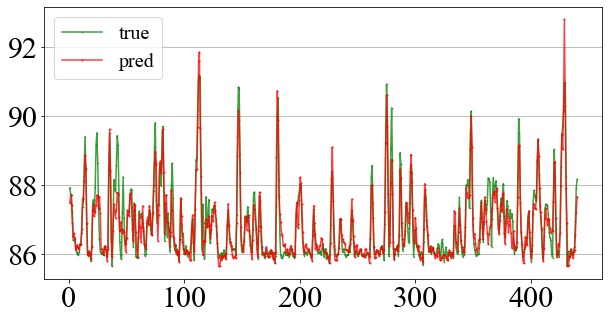

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.009462594985961914
epoch 0 : 100 ~ 200 0.008701702579855919
epoch 1
epoch 1 : 0 ~ 100 0.0035726851783692837
epoch 1 : 100 ~ 200 0.011682691052556038
epoch 2
epoch 2 : 0 ~ 100 0.0038508661091327667
epoch 2 : 100 ~ 200 0.012159029953181744
epoch 3
epoch 3 : 0 ~ 100 0.003715879051014781
epoch 3 : 100 ~ 200 0.012390339747071266
epoch 4
epoch 4 : 0 ~ 100 0.003394240979105234
epoch 4 : 100 ~ 200 0.0120350681245327
epoch 5
epoch 5 : 0 ~ 100 0.002901511499658227
epoch 5 : 100 ~ 200 0.010883410461246967
epoch 6
epoch 6 : 0 ~ 100 0.00241173361428082
epoch 6 : 100 ~ 200 0.009402464143931866
epoch 7
epoch 7 : 0 ~ 100 0.0022916740272194147
epoch 7 : 100 ~ 200 0.008267706260085106
epoch 8
epoch 8 : 0 ~ 100 0.0022276905365288258
epoch 8 : 100 ~ 200 0.007408503443002701
epoch 9
epoch 9 : 0 ~ 100 0.0021344295237213373
epoch 9 : 100 ~ 200 0.0067397356033325195
epoch 10
epoch 10 : 0 ~ 100 0.0021105946507304907
epoch 10 : 100 ~ 200 0.006196255329996347
epoch 

epoch 88 : 100 ~ 200 0.00026913025067187846
epoch 89
epoch 89 : 0 ~ 100 0.00042440780089236796
epoch 89 : 100 ~ 200 0.000844786234665662
epoch 90
epoch 90 : 0 ~ 100 0.00040238542715087533
epoch 90 : 100 ~ 200 0.00027919968124479055
epoch 91
epoch 91 : 0 ~ 100 6.162501085782424e-05
epoch 91 : 100 ~ 200 0.00045369527651928365
epoch 92
epoch 92 : 0 ~ 100 0.0010488855186849833
epoch 92 : 100 ~ 200 0.0007356299320235848
epoch 93
epoch 93 : 0 ~ 100 0.00024128484074026346
epoch 93 : 100 ~ 200 0.0008081443374976516
epoch 94
epoch 94 : 0 ~ 100 0.0005573347443714738
epoch 94 : 100 ~ 200 0.00020636194676626474
epoch 95
epoch 95 : 0 ~ 100 0.00011563904263311997
epoch 95 : 100 ~ 200 0.0002694650902412832
epoch 96
epoch 96 : 0 ~ 100 0.0003814001684077084
epoch 96 : 100 ~ 200 0.0002533225924707949
epoch 97
epoch 97 : 0 ~ 100 0.0006509782979264855
epoch 97 : 100 ~ 200 0.0015096461866050959
epoch 98
epoch 98 : 0 ~ 100 0.00024322522222064435
epoch 98 : 100 ~ 200 7.991291204234585e-05
epoch 99
epoch 99 :

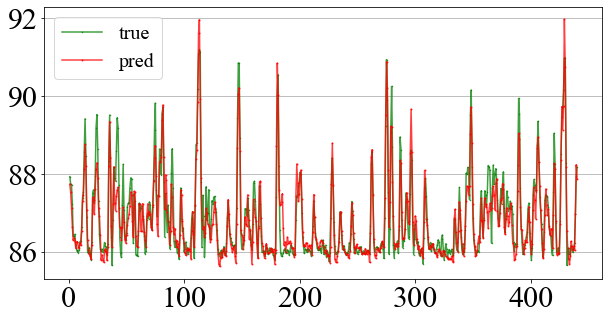

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.011995820328593254
epoch 0 : 100 ~ 200 0.005405460949987173
epoch 1
epoch 1 : 0 ~ 100 0.004104143474251032
epoch 1 : 100 ~ 200 0.0042146071791648865
epoch 2
epoch 2 : 0 ~ 100 0.0036042295396327972
epoch 2 : 100 ~ 200 0.0030409519094973803
epoch 3
epoch 3 : 0 ~ 100 0.0032621952705085278
epoch 3 : 100 ~ 200 0.0026548902969807386
epoch 4
epoch 4 : 0 ~ 100 0.002960792277008295
epoch 4 : 100 ~ 200 0.002565446076914668
epoch 5
epoch 5 : 0 ~ 100 0.0026465824339538813
epoch 5 : 100 ~ 200 0.0025408435612916946
epoch 6
epoch 6 : 0 ~ 100 0.002217260655015707
epoch 6 : 100 ~ 200 0.002403534483164549
epoch 7
epoch 7 : 0 ~ 100 0.0016291739884763956
epoch 7 : 100 ~ 200 0.0020590550266206264
epoch 8
epoch 8 : 0 ~ 100 0.0011222900357097387
epoch 8 : 100 ~ 200 0.001766235800459981
epoch 9
epoch 9 : 0 ~ 100 0.0008334856247529387
epoch 9 : 100 ~ 200 0.0016409304225817323
epoch 10
epoch 10 : 0 ~ 100 0.000666998268570751
epoch 10 : 100 ~ 200 0.00156638061162084

epoch 88 : 100 ~ 200 0.00034290034091100097
epoch 89
epoch 89 : 0 ~ 100 0.0005018117371946573
epoch 89 : 100 ~ 200 0.00015319252270273864
epoch 90
epoch 90 : 0 ~ 100 0.0002542953588999808
epoch 90 : 100 ~ 200 0.0004019581829197705
epoch 91
epoch 91 : 0 ~ 100 0.00048809341387823224
epoch 91 : 100 ~ 200 0.0003188917471561581
epoch 92
epoch 92 : 0 ~ 100 0.0008512891945429146
epoch 92 : 100 ~ 200 0.0004918552003800869
epoch 93
epoch 93 : 0 ~ 100 0.0002547313633840531
epoch 93 : 100 ~ 200 0.0001990345772355795
epoch 94
epoch 94 : 0 ~ 100 8.395366603508592e-05
epoch 94 : 100 ~ 200 0.0002758401387836784
epoch 95
epoch 95 : 0 ~ 100 0.0004265456518623978
epoch 95 : 100 ~ 200 0.00030503064044751227
epoch 96
epoch 96 : 0 ~ 100 0.00018582009943202138
epoch 96 : 100 ~ 200 0.00022148084826767445
epoch 97
epoch 97 : 0 ~ 100 0.00018663161608856171
epoch 97 : 100 ~ 200 0.0002683428465388715
epoch 98
epoch 98 : 0 ~ 100 9.743945702211931e-05
epoch 98 : 100 ~ 200 0.00027844036230817437
epoch 99
epoch 99 :

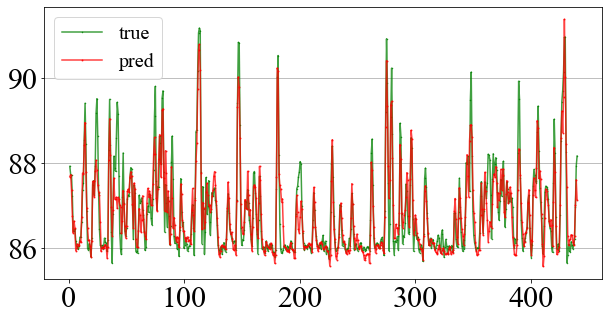

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.011028698645532131
epoch 0 : 100 ~ 200 0.004773300141096115
epoch 1
epoch 1 : 0 ~ 100 0.0043796696700155735
epoch 1 : 100 ~ 200 0.004588997457176447
epoch 2
epoch 2 : 0 ~ 100 0.0035745929926633835
epoch 2 : 100 ~ 200 0.00372740114107728
epoch 3
epoch 3 : 0 ~ 100 0.0030776229687035084
epoch 3 : 100 ~ 200 0.003185100154951215
epoch 4
epoch 4 : 0 ~ 100 0.0025889859534800053
epoch 4 : 100 ~ 200 0.002713687252253294
epoch 5
epoch 5 : 0 ~ 100 0.002054388402029872
epoch 5 : 100 ~ 200 0.0021777984220534563
epoch 6
epoch 6 : 0 ~ 100 0.0014866743003949523
epoch 6 : 100 ~ 200 0.0015831526834517717
epoch 7
epoch 7 : 0 ~ 100 0.0010697587858885527
epoch 7 : 100 ~ 200 0.001251049106940627
epoch 8
epoch 8 : 0 ~ 100 0.0008640848100185394
epoch 8 : 100 ~ 200 0.001131500001065433
epoch 9
epoch 9 : 0 ~ 100 0.0008141552098095417
epoch 9 : 100 ~ 200 0.0011171444784849882
epoch 10
epoch 10 : 0 ~ 100 0.0008701443439349532
epoch 10 : 100 ~ 200 0.001145365997217595

epoch 89 : 0 ~ 100 0.000901772640645504
epoch 89 : 100 ~ 200 0.00039282836951315403
epoch 90
epoch 90 : 0 ~ 100 0.0010378587758168578
epoch 90 : 100 ~ 200 0.000501170929055661
epoch 91
epoch 91 : 0 ~ 100 0.0009172746795229614
epoch 91 : 100 ~ 200 0.0007254158263094723
epoch 92
epoch 92 : 0 ~ 100 0.0006658275960944593
epoch 92 : 100 ~ 200 0.0003721585380844772
epoch 93
epoch 93 : 0 ~ 100 0.000862016633618623
epoch 93 : 100 ~ 200 0.0004956202465109527
epoch 94
epoch 94 : 0 ~ 100 0.0009113812702707946
epoch 94 : 100 ~ 200 0.0007047288818284869
epoch 95
epoch 95 : 0 ~ 100 0.0006838569534011185
epoch 95 : 100 ~ 200 0.0003545832878444344
epoch 96
epoch 96 : 0 ~ 100 0.0008116618846543133
epoch 96 : 100 ~ 200 0.0003918688162229955
epoch 97
epoch 97 : 0 ~ 100 0.0007176731014624238
epoch 97 : 100 ~ 200 0.0005091748898848891
epoch 98
epoch 98 : 0 ~ 100 0.0009500817395746708
epoch 98 : 100 ~ 200 0.00026127632008865476
epoch 99
epoch 99 : 0 ~ 100 0.0011049368185922503
epoch 99 : 100 ~ 200 0.0005113

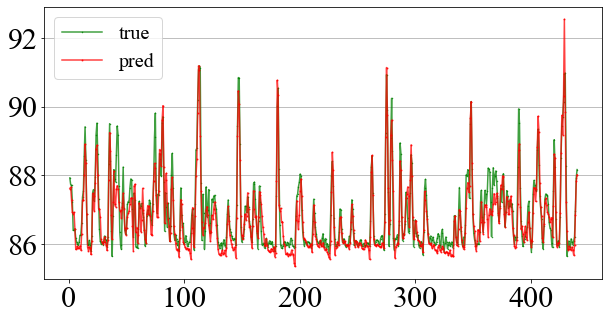

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.015516835264861584
epoch 0 : 100 ~ 200 0.010047373361885548
epoch 1
epoch 1 : 0 ~ 100 0.0035422954242676497
epoch 1 : 100 ~ 200 0.00769771495833993
epoch 2
epoch 2 : 0 ~ 100 0.003286495804786682
epoch 2 : 100 ~ 200 0.006328788585960865
epoch 3
epoch 3 : 0 ~ 100 0.0029671089723706245
epoch 3 : 100 ~ 200 0.005384703166782856
epoch 4
epoch 4 : 0 ~ 100 0.0025825565680861473
epoch 4 : 100 ~ 200 0.0045029958710074425
epoch 5
epoch 5 : 0 ~ 100 0.0021096444688737392
epoch 5 : 100 ~ 200 0.0036186426877975464
epoch 6
epoch 6 : 0 ~ 100 0.001582303666509688
epoch 6 : 100 ~ 200 0.0027804335113614798
epoch 7
epoch 7 : 0 ~ 100 0.0012734460178762674
epoch 7 : 100 ~ 200 0.0021278993226587772
epoch 8
epoch 8 : 0 ~ 100 0.0012351740151643753
epoch 8 : 100 ~ 200 0.0016848265659064054
epoch 9
epoch 9 : 0 ~ 100 0.0012875469401478767
epoch 9 : 100 ~ 200 0.0014169566566124558
epoch 10
epoch 10 : 0 ~ 100 0.0014184536412358284
epoch 10 : 100 ~ 200 0.0012571287807077

epoch 89 : 0 ~ 100 0.0009070214000530541
epoch 89 : 100 ~ 200 0.0008474549395032227
epoch 90
epoch 90 : 0 ~ 100 0.0006679563084617257
epoch 90 : 100 ~ 200 0.000413635658333078
epoch 91
epoch 91 : 0 ~ 100 0.0011687043588608503
epoch 91 : 100 ~ 200 0.0007353464025072753
epoch 92
epoch 92 : 0 ~ 100 0.0006776003865525126
epoch 92 : 100 ~ 200 0.000474661064799875
epoch 93
epoch 93 : 0 ~ 100 0.0005178340361453593
epoch 93 : 100 ~ 200 0.0024562503676861525
epoch 94
epoch 94 : 0 ~ 100 0.0018526732455939054
epoch 94 : 100 ~ 200 0.0003521097532939166
epoch 95
epoch 95 : 0 ~ 100 0.0008421242237091064
epoch 95 : 100 ~ 200 0.000512721308041364
epoch 96
epoch 96 : 0 ~ 100 0.0005781330401077867
epoch 96 : 100 ~ 200 0.0005921736010350287
epoch 97
epoch 97 : 0 ~ 100 0.0006114529678598046
epoch 97 : 100 ~ 200 0.0019884235225617886
epoch 98
epoch 98 : 0 ~ 100 0.0020532209891825914
epoch 98 : 100 ~ 200 0.00034256986691616476
epoch 99
epoch 99 : 0 ~ 100 0.0009494404075667262
epoch 99 : 100 ~ 200 0.00085380

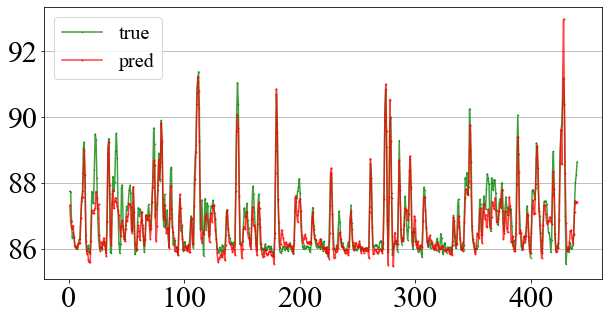

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.017783526331186295
epoch 0 : 100 ~ 200 0.03453504294157028
epoch 1
epoch 1 : 0 ~ 100 0.007956327870488167
epoch 1 : 100 ~ 200 0.021549087017774582
epoch 2
epoch 2 : 0 ~ 100 0.008171165362000465
epoch 2 : 100 ~ 200 0.01719225011765957
epoch 3
epoch 3 : 0 ~ 100 0.008017612621188164
epoch 3 : 100 ~ 200 0.014287838712334633
epoch 4
epoch 4 : 0 ~ 100 0.007793096359819174
epoch 4 : 100 ~ 200 0.011791644617915154
epoch 5
epoch 5 : 0 ~ 100 0.007485350128263235
epoch 5 : 100 ~ 200 0.009302720427513123
epoch 6
epoch 6 : 0 ~ 100 0.007007369305938482
epoch 6 : 100 ~ 200 0.006798942573368549
epoch 7
epoch 7 : 0 ~ 100 0.006136994808912277
epoch 7 : 100 ~ 200 0.004815359599888325
epoch 8
epoch 8 : 0 ~ 100 0.004620138090103865
epoch 8 : 100 ~ 200 0.003883498487994075
epoch 9
epoch 9 : 0 ~ 100 0.0034132502041757107
epoch 9 : 100 ~ 200 0.003650971222668886
epoch 10
epoch 10 : 0 ~ 100 0.0028870454989373684
epoch 10 : 100 ~ 200 0.0036165821366012096
epoch 11


epoch 89 : 100 ~ 200 0.0005630369414575398
epoch 90
epoch 90 : 0 ~ 100 0.0011699228780344129
epoch 90 : 100 ~ 200 0.0004428004031069577
epoch 91
epoch 91 : 0 ~ 100 0.0015542746987193823
epoch 91 : 100 ~ 200 0.0011216180864721537
epoch 92
epoch 92 : 0 ~ 100 0.0013673963258042932
epoch 92 : 100 ~ 200 0.001141080167144537
epoch 93
epoch 93 : 0 ~ 100 0.001249689026735723
epoch 93 : 100 ~ 200 0.0004608332528732717
epoch 94
epoch 94 : 0 ~ 100 0.0014719441533088684
epoch 94 : 100 ~ 200 0.0005388955469243228
epoch 95
epoch 95 : 0 ~ 100 0.0012463678140193224
epoch 95 : 100 ~ 200 0.0012999955797567964
epoch 96
epoch 96 : 0 ~ 100 0.0011512531200423837
epoch 96 : 100 ~ 200 0.0009613867732696235
epoch 97
epoch 97 : 0 ~ 100 0.0011624929029494524
epoch 97 : 100 ~ 200 0.0017074651550501585
epoch 98
epoch 98 : 0 ~ 100 0.001378494082018733
epoch 98 : 100 ~ 200 0.0014986128080636263
epoch 99
epoch 99 : 0 ~ 100 0.0014716454315930605
epoch 99 : 100 ~ 200 0.001342348987236619
data processing...
loading mode

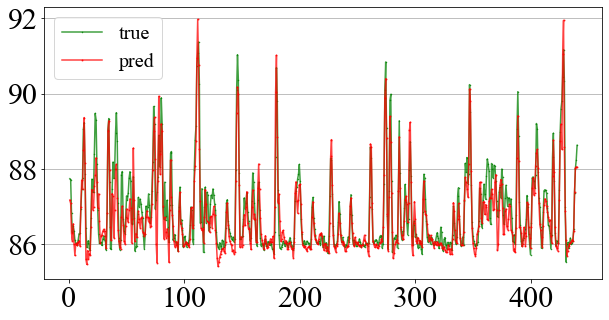

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.0161457397043705
epoch 0 : 100 ~ 200 0.04907052963972092
epoch 1
epoch 1 : 0 ~ 100 0.005436341278254986
epoch 1 : 100 ~ 200 0.034969814121723175
epoch 2
epoch 2 : 0 ~ 100 0.006568847689777613
epoch 2 : 100 ~ 200 0.033185504376888275
epoch 3
epoch 3 : 0 ~ 100 0.006974405143409967
epoch 3 : 100 ~ 200 0.0312177836894989
epoch 4
epoch 4 : 0 ~ 100 0.0073168277740478516
epoch 4 : 100 ~ 200 0.028636109083890915
epoch 5
epoch 5 : 0 ~ 100 0.007668147329241037
epoch 5 : 100 ~ 200 0.025033051148056984
epoch 6
epoch 6 : 0 ~ 100 0.007986652664840221
epoch 6 : 100 ~ 200 0.020147904753684998
epoch 7
epoch 7 : 0 ~ 100 0.0078920042142272
epoch 7 : 100 ~ 200 0.015038618817925453
epoch 8
epoch 8 : 0 ~ 100 0.006717228796333075
epoch 8 : 100 ~ 200 0.01154438965022564
epoch 9
epoch 9 : 0 ~ 100 0.005119725130498409
epoch 9 : 100 ~ 200 0.009542695246636868
epoch 10
epoch 10 : 0 ~ 100 0.0038563006091862917
epoch 10 : 100 ~ 200 0.008354662917554379
epoch 11
epoch 1

epoch 89 : 100 ~ 200 0.00041783772758208215
epoch 90
epoch 90 : 0 ~ 100 0.0011981634888797998
epoch 90 : 100 ~ 200 0.000340664031682536
epoch 91
epoch 91 : 0 ~ 100 0.0013511823490262032
epoch 91 : 100 ~ 200 0.000788058910984546
epoch 92
epoch 92 : 0 ~ 100 0.0013450554106384516
epoch 92 : 100 ~ 200 0.001277268398553133
epoch 93
epoch 93 : 0 ~ 100 0.001001835917122662
epoch 93 : 100 ~ 200 0.0011756343301385641
epoch 94
epoch 94 : 0 ~ 100 0.0015107005601748824
epoch 94 : 100 ~ 200 0.00146345398388803
epoch 95
epoch 95 : 0 ~ 100 0.0008059378014877439
epoch 95 : 100 ~ 200 0.0002719649637583643
epoch 96
epoch 96 : 0 ~ 100 0.0006494953413493931
epoch 96 : 100 ~ 200 0.0014957108069211245
epoch 97
epoch 97 : 0 ~ 100 0.0010325945913791656
epoch 97 : 100 ~ 200 0.0008529495680704713
epoch 98
epoch 98 : 0 ~ 100 0.0004090918810106814
epoch 98 : 100 ~ 200 0.0017231917008757591
epoch 99
epoch 99 : 0 ~ 100 0.0009642768418416381
epoch 99 : 100 ~ 200 0.0014868553262203932
data processing...
loading model

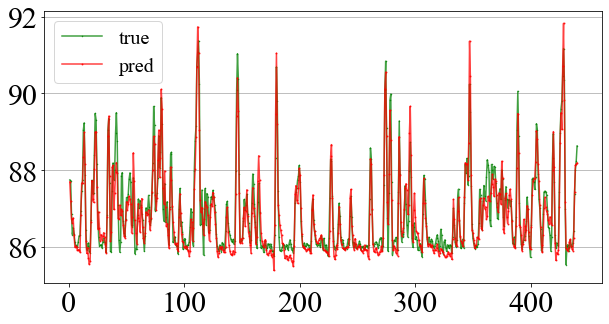

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.005288110114634037
epoch 0 : 100 ~ 200 0.03271760791540146
epoch 1
epoch 1 : 0 ~ 100 0.005588848609477282
epoch 1 : 100 ~ 200 0.031230885535478592
epoch 2
epoch 2 : 0 ~ 100 0.006113183684647083
epoch 2 : 100 ~ 200 0.02960248291492462
epoch 3
epoch 3 : 0 ~ 100 0.00639712531119585
epoch 3 : 100 ~ 200 0.027793124318122864
epoch 4
epoch 4 : 0 ~ 100 0.006686056964099407
epoch 4 : 100 ~ 200 0.025521406903862953
epoch 5
epoch 5 : 0 ~ 100 0.006974684540182352
epoch 5 : 100 ~ 200 0.02238910272717476
epoch 6
epoch 6 : 0 ~ 100 0.007269238121807575
epoch 6 : 100 ~ 200 0.0182355884462595
epoch 7
epoch 7 : 0 ~ 100 0.007219216320663691
epoch 7 : 100 ~ 200 0.013955587521195412
epoch 8
epoch 8 : 0 ~ 100 0.00594678521156311
epoch 8 : 100 ~ 200 0.01063297875225544
epoch 9
epoch 9 : 0 ~ 100 0.00455826660618186
epoch 9 : 100 ~ 200 0.008495907299220562
epoch 10
epoch 10 : 0 ~ 100 0.0036484375596046448
epoch 10 : 100 ~ 200 0.007126472890377045
epoch 11
epoch 11 

epoch 89 : 100 ~ 200 0.00038654886884614825
epoch 90
epoch 90 : 0 ~ 100 0.00036899017868563533
epoch 90 : 100 ~ 200 0.0002993752423208207
epoch 91
epoch 91 : 0 ~ 100 0.0013885155785828829
epoch 91 : 100 ~ 200 0.00029724970227107406
epoch 92
epoch 92 : 0 ~ 100 0.0007406549411825836
epoch 92 : 100 ~ 200 0.0009131677215918899
epoch 93
epoch 93 : 0 ~ 100 0.0019549184944480658
epoch 93 : 100 ~ 200 0.00031059185857884586
epoch 94
epoch 94 : 0 ~ 100 0.0007805213099345565
epoch 94 : 100 ~ 200 0.0002825964184012264
epoch 95
epoch 95 : 0 ~ 100 0.0015768602024763823
epoch 95 : 100 ~ 200 0.0006385110900737345
epoch 96
epoch 96 : 0 ~ 100 0.0010572687024250627
epoch 96 : 100 ~ 200 0.00021894252859055996
epoch 97
epoch 97 : 0 ~ 100 0.0003889474319294095
epoch 97 : 100 ~ 200 0.00012556754518300295
epoch 98
epoch 98 : 0 ~ 100 0.0011956891976296902
epoch 98 : 100 ~ 200 0.0005483227432705462
epoch 99
epoch 99 : 0 ~ 100 0.0007945813122205436
epoch 99 : 100 ~ 200 0.0002630113740451634
data processing...
lo

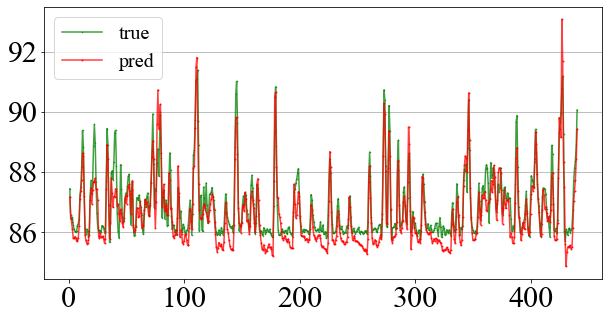

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.014078600332140923
epoch 0 : 100 ~ 200 0.04935314878821373
epoch 1
epoch 1 : 0 ~ 100 0.0063447533175349236
epoch 1 : 100 ~ 200 0.03170233592391014
epoch 2
epoch 2 : 0 ~ 100 0.0067122504115104675
epoch 2 : 100 ~ 200 0.029617156833410263
epoch 3
epoch 3 : 0 ~ 100 0.007155851926654577
epoch 3 : 100 ~ 200 0.027382757514715195
epoch 4
epoch 4 : 0 ~ 100 0.007780900690704584
epoch 4 : 100 ~ 200 0.0245729498565197
epoch 5
epoch 5 : 0 ~ 100 0.00851521734148264
epoch 5 : 100 ~ 200 0.020784463733434677
epoch 6
epoch 6 : 0 ~ 100 0.009166761301457882
epoch 6 : 100 ~ 200 0.016369648277759552
epoch 7
epoch 7 : 0 ~ 100 0.009124593809247017
epoch 7 : 100 ~ 200 0.012551987543702126
epoch 8
epoch 8 : 0 ~ 100 0.007941125892102718
epoch 8 : 100 ~ 200 0.0098200011998415
epoch 9
epoch 9 : 0 ~ 100 0.006273177918046713
epoch 9 : 100 ~ 200 0.00791621021926403
epoch 10
epoch 10 : 0 ~ 100 0.004845426417887211
epoch 10 : 100 ~ 200 0.006589418742805719
epoch 11
epoch 1

epoch 89 : 0 ~ 100 0.001241256482899189
epoch 89 : 100 ~ 200 0.0011419954244047403
epoch 90
epoch 90 : 0 ~ 100 0.000555553357116878
epoch 90 : 100 ~ 200 0.003677672240883112
epoch 91
epoch 91 : 0 ~ 100 0.00034877346479333937
epoch 91 : 100 ~ 200 0.0014702307526022196
epoch 92
epoch 92 : 0 ~ 100 0.0007539975340478122
epoch 92 : 100 ~ 200 0.0015563819324597716
epoch 93
epoch 93 : 0 ~ 100 0.0022174683399498463
epoch 93 : 100 ~ 200 0.0012932952959090471
epoch 94
epoch 94 : 0 ~ 100 0.0011843041284009814
epoch 94 : 100 ~ 200 0.0006264882977120578
epoch 95
epoch 95 : 0 ~ 100 0.0004648106114473194
epoch 95 : 100 ~ 200 0.0011580573627725244
epoch 96
epoch 96 : 0 ~ 100 0.0005482800188474357
epoch 96 : 100 ~ 200 0.0011724819196388125
epoch 97
epoch 97 : 0 ~ 100 0.00036724115489050746
epoch 97 : 100 ~ 200 0.0004166161234024912
epoch 98
epoch 98 : 0 ~ 100 0.0002958301338367164
epoch 98 : 100 ~ 200 0.00037548894761130214
epoch 99
epoch 99 : 0 ~ 100 0.0007518884376622736
epoch 99 : 100 ~ 200 0.000108

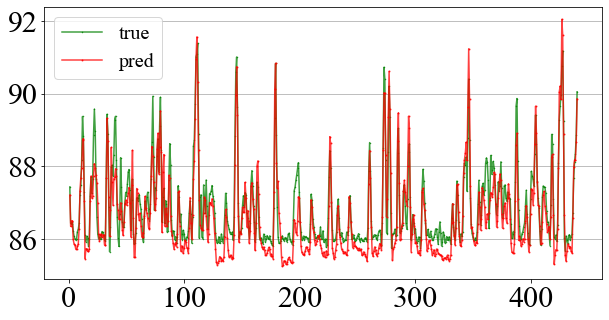

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.003275987459346652
epoch 0 : 100 ~ 200 0.031305424869060516
epoch 1
epoch 1 : 0 ~ 100 0.006327065639197826
epoch 1 : 100 ~ 200 0.03062540292739868
epoch 2
epoch 2 : 0 ~ 100 0.0069211372174322605
epoch 2 : 100 ~ 200 0.029623206704854965
epoch 3
epoch 3 : 0 ~ 100 0.007441700901836157
epoch 3 : 100 ~ 200 0.02840138040482998
epoch 4
epoch 4 : 0 ~ 100 0.00797108095139265
epoch 4 : 100 ~ 200 0.026638781651854515
epoch 5
epoch 5 : 0 ~ 100 0.008412094786763191
epoch 5 : 100 ~ 200 0.023841844871640205
epoch 6
epoch 6 : 0 ~ 100 0.008616306819021702
epoch 6 : 100 ~ 200 0.019749967381358147
epoch 7
epoch 7 : 0 ~ 100 0.00814349390566349
epoch 7 : 100 ~ 200 0.015638919547200203
epoch 8
epoch 8 : 0 ~ 100 0.006411315407603979
epoch 8 : 100 ~ 200 0.012538759037852287
epoch 9
epoch 9 : 0 ~ 100 0.004620091989636421
epoch 9 : 100 ~ 200 0.010539653711020947
epoch 10
epoch 10 : 0 ~ 100 0.003402185393497348
epoch 10 : 100 ~ 200 0.009392165578901768
epoch 11
epoc

epoch 89 : 0 ~ 100 0.00037161685759201646
epoch 89 : 100 ~ 200 0.0003155151498503983
epoch 90
epoch 90 : 0 ~ 100 0.00044592673657462
epoch 90 : 100 ~ 200 0.00012552486441563815
epoch 91
epoch 91 : 0 ~ 100 0.00028799136634916067
epoch 91 : 100 ~ 200 0.0006173198926262558
epoch 92
epoch 92 : 0 ~ 100 0.0002876080689020455
epoch 92 : 100 ~ 200 0.0001824949576985091
epoch 93
epoch 93 : 0 ~ 100 0.00028727890457957983
epoch 93 : 100 ~ 200 0.0006102484767325222
epoch 94
epoch 94 : 0 ~ 100 0.000284106150502339
epoch 94 : 100 ~ 200 0.00028089649276807904
epoch 95
epoch 95 : 0 ~ 100 0.00033494626404717565
epoch 95 : 100 ~ 200 0.00062741176225245
epoch 96
epoch 96 : 0 ~ 100 0.00030827047885395586
epoch 96 : 100 ~ 200 0.000783250667154789
epoch 97
epoch 97 : 0 ~ 100 0.000724098936188966
epoch 97 : 100 ~ 200 0.00030460438574664295
epoch 98
epoch 98 : 0 ~ 100 0.0002933642244897783
epoch 98 : 100 ~ 200 0.0014538423856720328
epoch 99
epoch 99 : 0 ~ 100 0.00039764889515936375
epoch 99 : 100 ~ 200 0.0002

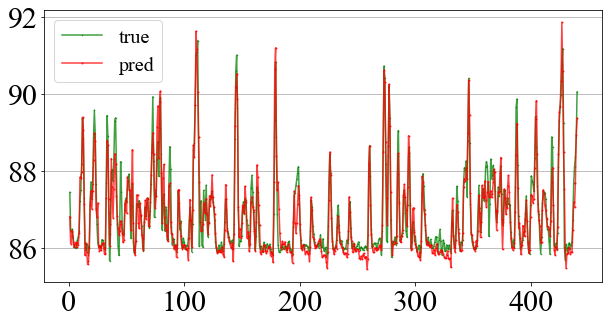

data processing...
epoch 0
epoch 0 : 0 ~ 100 0.004175400361418724
epoch 0 : 100 ~ 200 0.01449326891452074
epoch 1
epoch 1 : 0 ~ 100 0.0017500314861536026
epoch 1 : 100 ~ 200 0.020416688174009323
epoch 2
epoch 2 : 0 ~ 100 0.0019906852394342422
epoch 2 : 100 ~ 200 0.0211810152977705
epoch 3
epoch 3 : 0 ~ 100 0.0024596075527369976
epoch 3 : 100 ~ 200 0.021078037098050117
epoch 4
epoch 4 : 0 ~ 100 0.002936589065939188
epoch 4 : 100 ~ 200 0.020255103707313538
epoch 5
epoch 5 : 0 ~ 100 0.0033885918091982603
epoch 5 : 100 ~ 200 0.01847006380558014
epoch 6
epoch 6 : 0 ~ 100 0.0037947124801576138
epoch 6 : 100 ~ 200 0.015523448586463928
epoch 7
epoch 7 : 0 ~ 100 0.0040852720849215984
epoch 7 : 100 ~ 200 0.012337337248027325
epoch 8
epoch 8 : 0 ~ 100 0.00381981092505157
epoch 8 : 100 ~ 200 0.009827926754951477
epoch 9
epoch 9 : 0 ~ 100 0.0031849280931055546
epoch 9 : 100 ~ 200 0.007830817252397537
epoch 10
epoch 10 : 0 ~ 100 0.0026541464030742645
epoch 10 : 100 ~ 200 0.006474827416241169
epoch 1

epoch 88 : 100 ~ 200 0.0006303944392129779
epoch 89
epoch 89 : 0 ~ 100 0.00033555313711985946
epoch 89 : 100 ~ 200 0.0009870643261820078
epoch 90
epoch 90 : 0 ~ 100 0.00032781888148747385
epoch 90 : 100 ~ 200 0.0008159568533301353
epoch 91
epoch 91 : 0 ~ 100 0.00037938609602861106
epoch 91 : 100 ~ 200 0.0010892291320487857
epoch 92
epoch 92 : 0 ~ 100 0.0006857160478830338
epoch 92 : 100 ~ 200 0.0008003484690561891
epoch 93
epoch 93 : 0 ~ 100 0.00045308010885491967
epoch 93 : 100 ~ 200 0.001298977411352098
epoch 94
epoch 94 : 0 ~ 100 0.0002588452189229429
epoch 94 : 100 ~ 200 0.0006920400774106383
epoch 95
epoch 95 : 0 ~ 100 0.0002634841366671026
epoch 95 : 100 ~ 200 0.0009555384749546647
epoch 96
epoch 96 : 0 ~ 100 0.00047345375060103834
epoch 96 : 100 ~ 200 0.0005766904214397073
epoch 97
epoch 97 : 0 ~ 100 0.00022206059657037258
epoch 97 : 100 ~ 200 0.0006656247423961759
epoch 98
epoch 98 : 0 ~ 100 0.0001284606842091307
epoch 98 : 100 ~ 200 0.0014319898327812552
epoch 99
epoch 99 : 0 

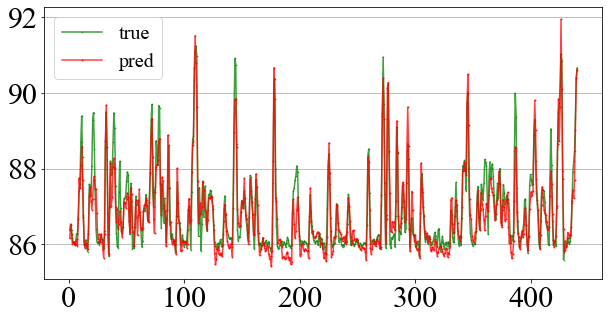

In [6]:
rmse_list = []
mae_list = []
r_squared_list = []
def LSTM_test(name, b):
    global MAX, MIN
    Dtr, Dte= nn_seq(file_name=name, batch_size=b)
    pred = []
    y = []
    print('loading model...')
    input_size, hidden_size, num_layers, output_size = 3, 64, 1, 1
    model = LSTM(input_size, hidden_size, num_layers, output_size, batch_size=b).to(device)
    model.load_state_dict(torch.load(LSTM_PATH)['model'])
    model.eval()
    print('predicting...')
    for (seq, target) in Dte:
        target = list(chain.from_iterable(target.data.tolist()))
        y.extend(target)
        seq = seq.to(device)
        seq_len = seq.shape[1]
        seq = seq.view(model.batch_size, seq_len, 3)  # (5, 24, 1)
        with torch.no_grad():
            y_pred = model(seq)
            y_pred = list(chain.from_iterable(y_pred.data.tolist()))
            pred.extend(y_pred)

    y, pred = np.array(y), np.array(pred)
    y = (MAX - MIN) * y + MIN
    pred = (MAX - MIN) * pred + MIN
    print('rmse:', get_rmse(y, pred))
    # plot
    plt.figure(1, figsize=(10, 5))
    font = {'family': 'serif',
        'serif': 'Times New Roman',
        'weight': 'normal',
        'size': 20}
    plt.rc('font', **font)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    
    x = [i for i in range(1, test_len+1)]
    x_smooth = np.linspace(np.min(x), np.max(x), 600)
    y_smooth = make_interp_spline(x, y)(x_smooth)
    plt.plot(x_smooth, y_smooth, c='green', marker='*', ms=1, alpha=0.75, label='true')

    y_smooth = make_interp_spline(x, pred)(x_smooth)
    plt.legend(loc = "best")
    plt.plot(x_smooth, y_smooth, c='red', marker='o', ms=1, alpha=0.75, label='pred')
    plt.grid(axis='y')
    plt.legend()
    plt.show()
    
    #保存预测结果
#     a1 = []
#     for i in range(len(pred)):
#         a1.append(pred[i].item())
#     df1 = pd.DataFrame(data=a1, columns=['y'])
#     df1.to_csv('E:\论文素材\数据/GRU_predict.csv',index=False)
    rmse_list.append(get_rmse(y, pred))
    mae_list.append(get_mae(y, pred))
    r_squared_list.append(computeCorrelation(y, pred))

t1 = datetime.datetime.now()
for i in range(30): 
    time_seq_len = i+1
    print("time_seq_len: ", time_seq_len)
    LSTM_train('E:\实验数据\python\LSTM_data\data.csv', 5)
    LSTM_test('E:\实验数据\python\LSTM_data\data.csv', 5)
t2 = datetime.datetime.now()
consume_time = (t2 - t1).seconds


2737 s


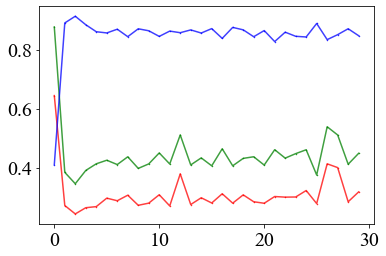

In [7]:
plt.plot(range(30), rmse_list, c='green', marker='*', ms=1, alpha=0.75, label='rmse')
plt.plot(range(30), mae_list, c='red', marker='*', ms=1, alpha=0.75, label='mae')
plt.plot(range(30), r_squared_list, c='blue', marker='*', ms=1, alpha=0.75, label='r_squared')
print(consume_time, 's')

In [10]:
#保存预测结果
a1 = []
a2 = []
a3 = []

for i in range(len(rmse_list)):
    a1.append(rmse_list[i])
    a2.append(mae_list[i])
    a3.append(r_squared_list[i])
    
df1 = pd.DataFrame(data=a1, columns=['y'])
df2 = pd.DataFrame(data=a2, columns=['y'])
df3 = pd.DataFrame(data=a3, columns=['y'])
    
df1.to_csv('E:\论文素材\数据/GRU_rese.csv',index=False)
df1.to_csv('E:\论文素材\数据/GRU_mae.csv',index=False)
df1.to_csv('E:\论文素材\数据/GRU_r_squared.csv',index=False)

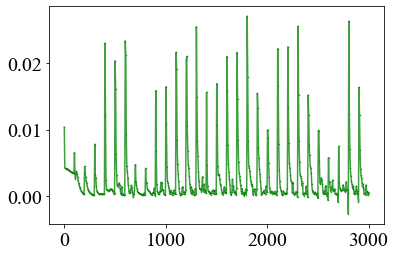

In [8]:
x = [i for i in range(1, len(ls)+1)]
x_smooth = np.linspace(np.min(x), np.max(x), 600)
y_smooth = make_interp_spline(x, ls)(x_smooth)
plt.plot(x_smooth, y_smooth, c='green', marker='*', ms=1, alpha=0.75, label='true')